<a href="https://colab.research.google.com/github/SolinSM/GAN/blob/main/CGAN_Model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***TDCGAN (v2)***

# **libraries**

In [ ]:
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 keras==2.15.0   #python 3.10.12

#for read csv file
import os
import pandas as pd
import numpy as np
import random


# pre-process
##for stop word
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

## not used now
#import unicodedata     # Remove accents
#import string

import sklearn

## for tokenization
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer      ## WordPunctTokenizer --> splits words based on punctuation boundaries.

## for divide data to (train / test/ validate)
from sklearn.model_selection import train_test_split


# for one-hor encode (sentence to 2D)
from sklearn.preprocessing import OneHotEncoder

# for TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# for plot
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder


# for TDCGAN , CGAN
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Concatenate,
    Embedding,
    Dense,
    LeakyReLU,
    BatchNormalization,
    Dropout,
    Reshape,
)

import keras
from keras.optimizers import Adam


import time
# taqadum in arabic , progress/process in english
from tqdm.notebook import tqdm
#from tqdm import tqdm


# Suppress warnings from numpy
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


import keras.backend as K
import numpy as np


# for Evaluate
from sklearn.metrics import classification_report


In [ ]:

print(tf. __version__)      # tensorflow version

!python --version           # python version

print(sklearn.__version__)         # scikit-learn version

print(keras.__version__)           # keras version

2.15.0
Python 3.10.12
1.2.2
2.15.0


# **definition**

In [ ]:

NUM_DISCRIMINATORS = 3
GENERATOR_DROPOUT_RATE = 0.2  #0.1
DISCRIMINATOR_DROPOUT_RATE = 0.3      #Adjust the dropout rate to prevent overfitting during training.
LEAKY_RELU_ALPA = 0.2

NUM_EPOCHS = 500      #1000
BATCH_SIZE = 128      #30
OPTIMIZER_LR = 0.0001                 # learning rate
OPTIMIZER_BETAS = (0.5, 0.999)

# Save losses for plotting
d0_real_losses = []   # left discriminator losses   (disc 0)
d0_fake_losses = []   # left discriminator losses   (disc 0)
d0_losses      = []   # discriminator losses        (disc 0)

d1_real_losses = []   # Middle discriminator losses (disc 1)
d1_fake_losses = []   # Middle discriminator losses (disc 1)
d1_losses      = []   # discriminator losses        (disc 1)

d2_real_losses = []   # right discriminator losses  (disc 2)
d2_fake_losses = []   # right discriminator losses  (disc 2)
d2_losses      = []   # discriminator losses        (disc 2)

g_losses       = []   # generator losses
d_losses       = []   # discriminator losses



# **Color list + TextStyle**

In [ ]:
colors_list = [
    'Red', 'Green', 'Blue', 'Purple', 'Orange', 'Pink', 'Brown', 'Yellow',
    'Cyan', 'Magenta', 'Lime', 'Teal', 'Lavender', 'Maroon', 'Navy', 'Olive', 'Silver', 'Gold',
    'Indigo', 'Turquoise', 'Beige', 'Crimson', 'Salmon','Tan','Lime', 'Fuchsia', 'Plum',
    'Tomato', 'Violet']

class TextStyle:
    # Font Styles
    BOLD = '\033[1m'
    DIM = '\033[2m'
    UNDERLINE = '\033[4m'
    BLINK = '\033[5m'
    REVERSE = '\033[7m'
    RESET_ALL = '\033[0m'

    # Font Colors
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'

    # Background Colors
    BG_BLACK = '\033[40m'
    BG_RED = '\033[41m'
    BG_GREEN = '\033[42m'
    BG_YELLOW = '\033[43m'
    BG_BLUE = '\033[44m'
    BG_MAGENTA = '\033[45m'
    BG_CYAN = '\033[46m'
    BG_WHITE = '\033[47m'


# **Read Multi Files csv**

In [ ]:
""" ----------------- Read CSV File Function ----------------- """
def read_csv_files(dataset_directory, percent):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Handling Read CSV Files ------------{TextStyle.RESET_ALL}")

  files = [f for f in os.listdir(dataset_directory) if f.endswith('.csv')]

  if files == []:
    print('Not found any csv files')
  else:
    print('Your files are: ', files)

    np_array_values = []
    data_df = pd.DataFrame()
    firstFile = True

    for file in files:
      file_path = os.path.join(dataset_directory, file)   # csv_file_path
      print('File Path: ', file_path)

      try:
        df = ''
        df = pd.read_csv(file_path, encoding = "ISO-8859-1")  #.head()   #,low_memory=False   ISO-8859-1
        total_rows = len(df)
        print('Total rows in df/file: ', total_rows)

        num_rows = int(total_rows * (percent / 100))
        print('Total rows in df/file 100%: ', num_rows)


        """ Start From Teacher Code """
        # Generate a list of random indices
        random_indices = random.sample(range(total_rows), num_rows)
        #print('random_indices: ' , random_indices)

        # Select the random rows from the DataFrame
        temp_df = df.iloc[random_indices]
        if(firstFile):
          # Concatenate all DataFrames into one
          data_df = temp_df.copy()
          firstFile = False
        else:
          # Concatenate all DataFrames into one
          data_df = pd.concat([data_df,temp_df], ignore_index=True)

        print(data_df)
        return data_df
        """ End From Teacher Code """

        ## Add DataFrame to new CSV file
        #new_csv_file_path = os.path.join(dataset_directory, 'new_sqli.csv')  # "/content/dataset/new_sqli.csv"
        #df.to_csv(new_csv_file_path, index=False)

      except Exception as e:
        print('Can not Read File called : ', file)
        print('File path: ', file_path)
        print("Errpr Exception e : ", e)


#""" ----------------- Apply Code ----------------- """
#dataset_directory = "/content/datasets"   #files_path
#percent = 100
#data = read_csv_files(dataset_directory,percent)


# **Pre-process**

## **Tokenization + filter_stop_words (Func. Used)**

In [ ]:
## ----- filter_stop_words ------ ##
"""
Filters stop words from a list of tokens, keeping words in the exception list.
Args:
    word_tokens: A list of tokens (words).
    except_stop_word: A set of stop words to be excluded from removal (optional).
Returns:
    A list of tokens with stop words removed, except for those in the exception list.
"""
def filter_stop_words(word_tokens):
    stop_words = set(stopwords.words('english'))  # Load default stop words
    except_stop_word = set(['and', 'or', 'where', 'from', 'over'])  # Exception list defined here

    filtered_sentence = []
    for w in word_tokens:
        if w in except_stop_word or w not in stop_words:
            filtered_sentence.append(w)

    return filtered_sentence





## ----- Tokenization ------ ##
"""
# Tokenization + stop word
Handle Main column in dataset 'sentence'
by encoding it using (Tokenization handlling OOV + stop_word  , TfidfVectorizer )
OOV :
    ensures any new words in the test data are mapped to a common OOV token.
    ensure robustness and accuracy when dealing with new, unseen words.
"""
def tokenization_text(sentences, x_name = ''):      #sentences):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Tokenization + stop word (" , x_name , f") ------------{TextStyle.RESET_ALL}")

    #sentences = X['sentence']
    print('sentences: ' , len(sentences) )

    #define OOV token text to use it when new token appear and not in train tokens data
    #oov_token='<OOV>'

    tokenizer = WordPunctTokenizer()
    #tokenizer.oov_token = '<UNK>'   # '<OOV>'
    tokens = []

    for sentence in sentences:
        #word_tokens = word_tokenize(sentence)
        word_tokens = tokenizer.tokenize(sentence)

        # Replace OOV words with the specified token
        #word_tokens_with_oov = [token if token in tokenizer.vocab else oov_token for token in word_tokens]

        # stop_words  (filter tokeniz word by remove any stop word with except some word as from, where ... etc)
        filtered_tokens = filter_stop_words(word_tokens)


        ########tokens.extend(filtered_tokens)    ## for test 8:18 20-5-2024    #######
        tokens.append(filtered_tokens)

        # Join tokens back to string for TF-IDF
        #tokens.append(' '.join(filtered_tokens))


    #print('len tokens before unique: ', len(tokens))
    #print('1 tokens: ', tokens )

    # Get unique tokens ( Remove duplicates using set() and convert back to list )
    ######tokens = list(set(tokens))    #######
    #print('len tokens after unique: ', len(tokens))
    #print('2 tokens: ', tokens )

    print("tokens len:", len(tokens) )
    """
    i = 0
    for token in tokens:
      if i < 5:
        print("tokens:", tokens[i])
        i = i + 1
      else:
        break
    """
    return tokens



## **one_hot_encoder (Func Used)**

In [ ]:
## ----- one_hot_encoder_func ------ ##

def one_hot_encoder_func(X, one_hot_cols):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform one-hot encoding ------------{TextStyle.RESET_ALL}")
    one_hot_encoded_df = X.copy()

    # Perform one-hot encoding
    one_hot_encoded_1 = pd.get_dummies(one_hot_encoded_df, columns=one_hot_cols, prefix=one_hot_cols)
    #print('one_hot_encoded : ', one_hot_encoded_1)

    # Get only columns that is original columns and needed as them + not neet to convert them from boolean to int
    origin_needed_cols = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                            not any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Get only columns that created new by one-hoe-encoder (get_dummies)
    one_hot_cols_df = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                          any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Convert one_hot_cols_df values from boolean to integers (1 and 0)
    one_hot_cols_df = one_hot_cols_df.astype(int)

    # Concatenate the one_hot_cols_df with the origin_needed_cols
    X = pd.concat([origin_needed_cols, one_hot_cols_df], axis=1)
    print('end one hot encoder : \n', X.head())

    """
      Ex of previous row:
          i  color  size              i     color_blue   color_red   size_M   size_S
          ---------------           ---------------------------------------------------
          0   red    S                0         0            1          0       1
          1   blue   M          ==>   1         1            0          1       0
          2   blue   S                2         1            0          0       1
    """

    return X


## **target_encode (Func. Used)**

In [ ]:
## ----- target_encode ------ ##

"""
  # target encoding/mean encoding
  # useful for encoding categorical features into numerical features based on their relationship with the target variable.
  # target_column : deciding it will depend on the objective of your analysis or model training.
  # It is typically the variable you're trying to predict in a supervised learning task.

  NOTE::
    Target-encode might not be ideal for SQL sentences
      1. SQL sentences are unstructured text data with potentially high cardinality and no inherent ordering.
      2. Target encoding works better for categorical variables with a clear relationship to the target,
          rather than free-form text.
"""
def target_encode(X, y, target_encode_cols, target_column):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform target encoding ------------{TextStyle.RESET_ALL}")

    target_encoded_df = X.copy()
    print('target_encoded_df: ', target_encoded_df.head())

    # this colum choisen because it is needed to predict sentence is normal or sqli
    #target_column = class_Col # y   #encoding_col
    for col in target_encode_cols:

        # Check if the column exists
        if col not in X.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame")

        # Concate y  --> class_Col to X now then next remove it
        #class_Col_df = y.copy()
        X = pd.concat([X, y], axis=1)

        # Calculate the mean target value for each category  (the mean float no for each category in column)
        mean_encoding = X.groupby(col)[target_column].mean()
        print('mean_encoding: ', mean_encoding.head())

        # Map the mean values back to the DataFrame
        target_encoded_df[col + '_encoded'] = X[col].map(mean_encoding)
        #print('target_encoded_df: ', target_encoded_df.head())

        # Drop class_Col added to do this part
        X = X.drop(target_column, axis=1)

        # Drop the original categorical column
        target_encoded_df = target_encoded_df.drop(col, axis=1)
        print('target_encoded_df: ', target_encoded_df.head())

        X = target_encoded_df

    return X



## **pre-process 1**

In [ ]:
##### work result 1 in png images
def load_and_preprocess_data(df_data):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Pre-Proccess Data ------------{TextStyle.RESET_ALL}")

    # ----------- Check for NaN Values ------------- #
    print("Checking for NaN vallues ...")
    if df_data.isnull().values.any():
        print("NaN values found in the dataset. Handling missing values...")
        # Handling missing values by imputing with mean (you can choose other methods as well)
        df_data = df_data.fillna(df_data.mean())
    df_data.replace([np.inf, -np.inf,np.nan,np.NAN],0, inplace=True)

    if df_data.isnull().sum().sum() == 0 : # and np.isinf(df_data.values).sum() == 0 :
        print('Done Handling missing values')


    # ----------- lowercase + strip 'sentence' ------------- #
    # Convert to lowercase & Remove spaces in start and end
    df_data['sentence'] = df_data['sentence'].str.lower().str.strip()


    # ------------------------------------  separate target from predictors ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- separate target from predictors -------{TextStyle.RESET_ALL}")

    class_Col = 'attack_type'
    df_data['len_payload'] = df_data['len_payload'].astype(int)
    df_data[class_Col] = df_data[class_Col].astype(int)     #pd_frames['attack_type'] = pd_frames['attack_type'].astype(int)
    y = df_data[class_Col]      # main col to classify at end (class_Col --> attack_type)
    n_classes = y.nunique()      # no. classes/category in class_Col (attack_type)     n_classes = pd_frames['attack_type'].nunique()


    # ------------------------------------ Apply encoding for categorical columns if any ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Handling Categorical Features -------{TextStyle.RESET_ALL}")

    # all categorical columns (any column with object dataType ant its value not number)
    categorical_cols = [cname for cname in df_data.columns if
                        df_data[cname].dtype == "object"]
    print("Categorical columns len: ", len(categorical_cols))
    print("Categorical columns: ", categorical_cols)

    # Columns that will be one-hot encoded
    # X[cname].nunique() < 4   : less that 4 categories in the column
    one_hot_cols = [cname for cname in df_data.columns if
                      df_data[cname].nunique() < 4 and
                      df_data[cname].dtype == "object"]
    print('one_hot_cols : ', one_hot_cols)
    print("No. Columns need to encoded using one-hot-encoding: ", len(one_hot_cols))

    # Skip this columns because it needs to use TfidFVectorizer With it
    skip_cols = [main_text_col]

    # Columns that will be target encoded  (will get columns with more than 4 categories in it :: like 'sentence' column)
    target_encode_cols = list(set(categorical_cols)-set(one_hot_cols) - set(skip_cols) )
    print('target_encode_cols : ', target_encode_cols)
    print("No. Columns need to encoded using target-encoding: ", len(target_encode_cols))


    # Encode categorical columns if there is any
    if(len(categorical_cols) > 0):

      # to perform one-hot encoding on specified columns of a DataFrame.
      if(len(one_hot_cols)> 0):
        df_data = one_hot_encoder_func(df_data, one_hot_cols)

      if(len(target_encode_cols) > 0):
        target_column = class_Col
        df_data = target_encode(df_data, y, target_encode_cols, target_column)

    else:
      print("No categorical columns, nothing todo")


    # ------------------------------------ TfidfVectorizer ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- TfidfVectorizer -------{TextStyle.RESET_ALL}")
    tfidf_vectorizer = TfidfVectorizer(dtype='float32')
    X_tfidf_values = tfidf_vectorizer.fit_transform(df_data['sentence'])
    X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()

    df_data1 = df_data.copy()
    df_data1.drop(columns=['sentence'], inplace=True)
    df_tfidf = pd.DataFrame(X_tfidf_values.toarray(), columns=X_tfidf_selected_features)

    # Concatenate TF-IDF features with the original data excluding the sentence column
    x_data = pd.concat([df_data1, df_tfidf], axis=1)    #.drop(['sentence'], axis=1)


    # ------------------------------------ train_test_split ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Divide the dataset into training (70%) and testing (30%) -------{TextStyle.RESET_ALL}")

    X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.3, random_state=42)

    y_train = pd.DataFrame(y_train, columns=[class_Col])        #'attack_type'
    y_test  = pd.DataFrame(y_test,  columns=[class_Col])

    print('X_train head: ', X_train.head)
    print('y_train head: ', y_train.head)

    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    return n_classes, X_train, X_test, y_train, y_test#,, encoder


## **pre-process 2**

### **for test**

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

"""
# Step 1: Create the DataFrame
data = {
    'sentence': ['1 or 1=1', 'hi nora', 'all is mine', 'hi\'--', 'select user form user_tb --'],
    'attack_type': ['SQLi', 'normal', 'normal', 'SQLi', 'SQLi']
}
df = pd.DataFrame(data)
"""
# Step 1: Create the DataFrame
dataset_directory = "/content/datasets"   #files_path
percent = 100
data_df = read_csv_files(dataset_directory,percent)
data = data_df
print('len data : ' , len(data))

class_Col = 'attack_type'
min_rows_per_class = 2000  #50000
origin_data = data



# Step 2: One-hot encode the 'attack_type' column
encoder = OneHotEncoder(sparse=False)
encoded_attack_type = encoder.fit_transform(data[['attack_type']])
encoded_attack_type_df = pd.DataFrame(encoded_attack_type, columns=encoder.get_feature_names_out(['attack_type']))

# Concatenate the encoded attack_type with the original DataFrame
data = pd.concat([data.drop('attack_type', axis=1), encoded_attack_type_df], axis=1)


# Step 3: Identify the feature columns (X) and the target columns (y)
# Assuming the target columns are all the one-hot encoded columns (with 'attack_type_' prefix)
# Automatically find the target columns based on the columns added during encoding
target_columns = [col for col in data.columns if col.startswith('attack_type_')]

# Features are all the other columns
feature_columns = [col for col in data.columns if col not in target_columns]

X = data[feature_columns]
y = data[target_columns]


# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training data:\n")
print("X_train : \n", X_train , '\n')
print("y_train : \n", y_train)
print("\nTesting data:")
print(X_test)
print(y_test)

------------ Handling Read CSV Files ------------
Your files are:  ['SQLiDataset_3_b_4000.csv']
File Path:  /content/datasets/SQLiDataset_3_b_4000.csv
Total rows in df/file:  4000
Total rows in df/file 100%:  4000
                                               sentence attack_type  \
3152                                        empel6tarse      normal   
3763                               c/ pontevedra 25, 6a      normal   
1923  ' UNION ALL SELECT NULL, NULL, NULL, NULL-- AN...        SQLi   
3003                                               nima      normal   
3517                                          83016924b      normal   
...                                                 ...         ...   
1698  '  )  )   UNION ALL SELECT NULL, NULL, NULL, N...        SQLi   
309   "  )  )   )  UNION ALL SELECT NULL, NULL, NULL...        SQLi   
3378   However , repertoire also includes emotive wa...      normal   
1764                        ; SELECT PG_SLEEP ( 5 ) ;--        SQLi   
2406 

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

### **Our pre-process**

In [ ]:

def load_and_preprocess_data1(df_data):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Pre-Proccess Data ------------{TextStyle.RESET_ALL}")

    # ----------- Check for NaN Values ------------- #
    print("Checking for NaN vallues ...")
    if df_data.isnull().values.any():
        print("NaN values found in the dataset. Handling missing values...")
        # Handling missing values by imputing with mean (you can choose other methods as well)
        df_data = df_data.fillna(df_data.mean())
    df_data.replace([np.inf, -np.inf,np.nan,np.NAN],0, inplace=True)

    if df_data.isnull().sum().sum() == 0 : # and np.isinf(df_data.values).sum() == 0 :
        print('Done Handling missing values')


    # ----------- lowercase + strip 'sentence' ------------- #
    # Convert to lowercase & Remove spaces in start and end
    df_data['sentence'] = df_data['sentence'].str.lower().str.strip()


    # ------------------------------------  separate target from predictors ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- separate target from predictors -------{TextStyle.RESET_ALL}")

    # Step 1 : define targent column name and no. class in it
    class_Col = 'attack_type'
    n_classes = df_data[class_Col].nunique()      # no. classes/category in class_Col (attack_type)     n_classes = pd_frames['attack_type'].nunique()

    # Step 2: define datatype for columns
    df_data['len_payload'] = df_data['len_payload'].astype(int)


    if df_data[class_Col].dtype == 'object' :
        y_datatype = 'object'
        # Step 3: Convert Target Column 'attack_type'
        # 3.1 : Convert the 'attack_type' column to One-hot encode
        #encoder = OneHotEncoder(sparse=False)
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_attack_type = encoder.fit_transform(df_data[[class_Col]])
        encoded_attack_type_df = pd.DataFrame(encoded_attack_type, columns=encoder.get_feature_names_out([class_Col]))

        # 3.2 : Concatenate the encoded attack_type with the original DataFrame
        df_data = pd.concat([df_data.drop(class_Col, axis=1), encoded_attack_type_df], axis=1)
        df_data1_copy = df_data.copy()

        # Step 4: Identify the feature columns (X) and the target columns (y)
        # Assuming the target columns are all the one-hot encoded columns (with 'attack_type_' prefix)
        # Automatically find the target columns based on the columns added during encoding
        target_columns = [col for col in df_data.columns if col.startswith('attack_type_')]

        # Features are all the other columns
        feature_columns = [col for col in df_data.columns if col not in target_columns]

        df_data1 = df_data[feature_columns]
        y = df_data[target_columns]
        X = df_data1

    else:
        y_datatype = 'int'
        df_data[class_Col] = df_data[class_Col].astype(int)     #pd_frames['attack_type'] = pd_frames['attack_type'].astype(int)
        y = df_data[class_Col]      # main col to classify at end (class_Col --> attack_type)

        # remove y column (class_Col) from data columns list
        df_data1 = df_data.copy()
        df_data1.drop(columns=[class_Col], inplace=True)         #X.drop([class_Col], axis=1, inplace=True)
        #X_columns = df_data1.columns       #['sentence', 'len_payload', ....]
        X = df_data1


    print('X : ' , X)
    print('y: ', y)
    #print('y cols: ', y.columns)
    #y_columns = [col for col in y.columns]
    #print('y_columns: ', y_columns)



    # ------------------------------------ Apply encoding for categorical columns if any ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Handling Categorical Features -------{TextStyle.RESET_ALL}")

    # all categorical columns (any column with object dataType ant its value not number)
    categorical_cols = [cname for cname in X.columns if
                        X[cname].dtype == "object"]
    print("Categorical columns len: ", len(categorical_cols))
    print("Categorical columns: ", categorical_cols)

    # Columns that will be one-hot encoded
    # X[cname].nunique() < 4   : less that 4 categories in the column
    one_hot_cols = [cname for cname in X.columns if
                      X[cname].nunique() < 4 and
                      X[cname].dtype == "object"]
    print('one_hot_cols : ', one_hot_cols)
    print("No. Columns need to encoded using one-hot-encoding: ", len(one_hot_cols))

    # Skip this columns because it needs to use TfidFVectorizer With it
    skip_cols = [main_text_col]

    # Columns that will be target encoded  (will get columns with more than 4 categories in it :: like 'sentence' column)
    target_encode_cols = list(set(categorical_cols)-set(one_hot_cols) - set(skip_cols) )
    print('target_encode_cols : ', target_encode_cols)
    print("No. Columns need to encoded using target-encoding: ", len(target_encode_cols))


    # Encode categorical columns if there is any
    if(len(categorical_cols) > 0):

      # to perform one-hot encoding on specified columns of a DataFrame.
      if(len(one_hot_cols)> 0):
        X = one_hot_encoder_func(X, one_hot_cols)

      if(len(target_encode_cols) > 0):
        target_column = class_Col
        X = target_encode(X, y, target_encode_cols, target_column)

    else:
      print("No categorical columns, nothing todo")




    # ------------------------------------ train_test_split ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Divide the dataset into training (70%) and testing (30%) -------{TextStyle.RESET_ALL}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("Training data:\n")
    print("X_train : \n", X_train , '\n')
    print("y_train : \n", y_train)

    if y_datatype == 'int':
        y_train = pd.DataFrame(y_train, columns=[class_Col])        #'attack_type'
        y_test  = pd.DataFrame(y_test,  columns=[class_Col])

    print(f"Training rows (70% of Dataset)", "X_train shape: " , X_train.shape , " -- y_train shape: ", y_train.shape)
    print(f"Testing rows (30% of Dataset)", "X_test shape: " , X_test.shape , " -- y_test shape: ", y_test.shape)

    print('X_train head: ', X_train.head)
    print('y_train head: ', y_train.head)

    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    origin_x_train = X_train
    origin_x_test = X_test



    # ------------------------------------ Tokenization ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Tokenization -------{TextStyle.RESET_ALL}")

    X_train_tokenized = tokenization_text(X_train['sentence'], 'x_train')
    X_test_tokenized = tokenization_text(X_test['sentence'], 'x_test')

    # Join tokens back into strings for each sentence
    X_train_joined_sentences = [' '.join(tokens) for tokens in X_train_tokenized]     #X_train_copy['sentence_joined'] = ' '.join(X_train_tokenized)
    X_test_joined_sentences = [' '.join(tokens) for tokens in X_test_tokenized]
    #/print('joined_sentences: ' , joined_sentences)



    # ------------------------------------ TfidfVectorizer ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- TfidfVectorizer -------{TextStyle.RESET_ALL}")
    tfidf_vectorizer = TfidfVectorizer(dtype='float32')

    ## X_train
    #X_tfidf_values = tfidf_vectorizer.fit_transform(X_train['sentence'])      # without Tokenization step
    X_tfidf_values = tfidf_vectorizer.fit_transform(X_train_joined_sentences)      # With Tokenization Step

    X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()

    df_x_train = X_train.copy()
    df_x_train.drop(columns=['sentence'], inplace=True)
    df_tfidf_x_train = pd.DataFrame(X_tfidf_values.toarray(), columns=X_tfidf_selected_features)

    # Concatenate TF-IDF features with the original data excluding the sentence column
    x_train_data = pd.concat([df_x_train, df_tfidf_x_train], axis=1)


    ## X_test
    #X_test_tfidf_values = tfidf_vectorizer.transform(X_test['sentence'])      # without Tokenization step
    X_test_tfidf_values = tfidf_vectorizer.transform(X_test_joined_sentences)       # With Tokenization Step

    X_test_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()

    df_x_test = X_test.copy()
    df_x_test.drop(columns=['sentence'], inplace=True)
    df_tfidf_x_test = pd.DataFrame(X_test_tfidf_values.toarray(), columns=X_test_tfidf_selected_features)

    # Concatenate TF-IDF features with the original data excluding the sentence column
    x_test_data = pd.concat([df_x_test, df_tfidf_x_test], axis=1)
    print('end tfidf')



    # ------------------------------------ MinMaxScaler ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Scaling Features using 'MinMaxScaler' -------{TextStyle.RESET_ALL}")
    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(x_train_data)     #, axis=1)
    X_test_scaled = scaler.transform(x_test_data)           #, axis=1)

    # Convert the scaled numerical features back to DataFrames
    x_train_data = pd.DataFrame(X_train_scaled, columns=x_train_data.columns)     #X_train_scaled_df
    x_test_data = pd.DataFrame(X_test_scaled, columns=x_test_data.columns)        #X_test_scaled_df



    # ------------------------------------ PCA for feature selection ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- PCA for feature selection -------{TextStyle.RESET_ALL}")

    n_components = 0.90   #0.95
    pca = PCA(n_components=n_components, random_state=453)
    #print('pca: ' , pca)


    ## ------>> X_train << ------ ##
    print('pca x_train data')
    # Fit & Transform PCA on the training data
    X_train_pca = pca.fit_transform(x_train_data)

    # Convert PCA results back to DataFrames and concatenate with the original non-sentence columns
    # Generate new feature names for PCA components
    train_pca_feature_names = [f'pca_{i+1}' for i in range(X_train_pca.shape[1])]
    X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=train_pca_feature_names)      # Create a DataFrame with the PCA-transformed data
    x_train_data = X_train_pca_df
    print('end x_train_data')


    ## ------>> X_test << ------ ##
    print('pca x_test data')
    X_test_pca = pca.transform(x_test_data)
    test_pca_feature_names = [f'pca_{i+1}' for i in range(X_test_pca.shape[1])]
    X_test_pca_df = pd.DataFrame(data=X_test_pca, columns=test_pca_feature_names)
    x_test_data = X_test_pca_df
    print('end x_test_data')



    # variance ratio : show how much information (variance) can be attributed to each of the principal components.
    # Calculate explained variance ratio and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance      = np.cumsum(explained_variance_ratio)    # Calculates the cumulative explained variance ratio for each component.
    #print('explained_variance_ratio: ', explained_variance_ratio)
    #print('cumulative_variance: ', cumulative_variance)


    # Plot component variance and cumulative variance
    plt.figure(figsize=(12, 4))
    colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']

    # Plot component variance with percentages
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, label='Component Variance')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', color='r', label='Cumulative Variance')

    plt.title('Variance Explained by Principal Components\n Dataset ')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of Variance Explained (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


    """
    # Combine the PCA-transformed features with the target variable
    print('pca concat')
    x_train_data = pd.concat([X_train_pca_df, y_train], axis=1)
    print('pca concat - end x_train_data')
    x_test_data  = pd.concat([X_test_pca_df, y_test], axis=1)
    print('pca concat - end x_test_data')
    """

    print('x_train_data head', x_train_data.head)
    print('X_train_pca_df shape: ', x_train_data.shape)
    print('x_test_data shape: ', x_test_data.shape)


    return n_classes, x_train_data, x_test_data, y_train, y_test, origin_x_train, origin_x_test , y_datatype



# **Implement TDCGAN Models**

## **build_generator**

The model of the generator is a deep multi-layer perceptron (MLP) composed of an input layer, output layer and four hidden layers. Initially, the generator takes a point from the latent space to generate new data. The latent space is a multi-dimensional hypersphere normal distributed points, where each variable is drawn from the distribution of the data in the dataset. An embedded layer in the generator creates a vector representation for the generated point.
The generator model has four hidden layers. The first one is composed of 256 neurons with a rectified linear unit (ReLU) activation function. An embedded layer is used between hidden layers to efficiently map input data from a high-dimension to lower-dimension space. This allows the neural network to learn the data relationship and process it efficiently. The second hidden layer consists of 128 neurons, the third has 64 neurons and the last one has 32 neurons, with the ReLU activation function used with them all, and a regularization dropout of 20% is added to avoid overfitting. The output layer is activated using the Softmax activation function with 14 neurons as the number of features in the dataset.

In [ ]:
"""
Creates a generator model for text generation using a deep MLP.

Args:
    input_dim  : The dimension of the latent space.  (latent_dim)
    num_classes: The size of the vocabulary (number of unique words).  ((get it by tokeniz))  (vocabulary_size)
    GENERATOR_DROPOUT_RATE : it is 20% ==> 0.2

Returns:
    A TensorFlow Keras model representing the text generation GAN generator.
"""
def build_generator(input_dim, num_classes):   # vocabulary_size / num_class
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_generator ------------{TextStyle.RESET_ALL}")

  GENERATOR_DROPOUT_RATE = 0.2

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  noise = Input(shape=(input_dim,), name='noise')    # latent space noise (Features , ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')  # no need for One-hot encoded label, its numeric
  print('len noise: ', noise.shape[1])

  #concatenated = Concatenate()([data, label])
  # Concatenate features and label  (Concatenate along the last dimension)
  """  Concatenation: A Concatenate layer is used to combine the features and label along the last dimension (axis=-1).
      This creates a single input for the subsequent hidden layers in the discriminator model."""
  concatenated = Concatenate()([noise, label])   #Concatenate(axis=-1) is defualt

  # Embedded layer to map noise to lower-dimensional space
  # It creates a vector representation for the generated point.
  hidden = Embedding(input_dim, num_classes // 2)(concatenated)  # Adjust embedding dim as needed

  # Hidden layers with ReLU activation and dropout
  hidden = Dense(256, activation='relu')(concatenated)  #(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(128, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(64, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(32, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  # Output layer with Softmax activation
  generated_text = Dense(input_dim, activation='softmax', name='generated_text')(hidden)
  print('generated_text shape: ', generated_text.shape)

  # Create the generator model
  generator_model = Model(inputs=[noise, label], outputs=generated_text, name='generator')

  generator_model.compile(
      loss='categorical_crossentropy', #'binary_crossentropy',
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics=['accuracy']
  )

  return generator_model

## **build_discriminator**

In the TDCGAN architecture consists of three discriminators. Each discriminator is a deep neural network with different architecture and different parameter settings. Each discriminator’s role is to extract features from the output of the generator and classify the data with varying levels of accuracy for each them. The model aims to classify data into two groups: normal flows for the background traffic with 0 representation, and anomaly flows for the attack data with 1 representation. The discriminator distinguishes the new data generated by the generator from the true data distribution. It classifies them as either real or fake. Subsequently, the discriminator undergoes updates to improve its ability to distinguish between real and fake samples in the subsequent round. The discriminators try to classify the data into their corresponding class, which is done through a fully connected MLP network.

Each discriminator is a MLP model with a different number of hidden layers, different number of neurons and different dropout percentage. The first discriminator is composed of 3 hidden layers with 100 neurons for each and 10% dropout regularization. The second has five hidden layers with 64, 128, 256, 512, and 1024 neurons for each layer, respectively. The dropout percentage is 40%. The last discriminator has 4 hidden layers with 512, 256, 128, and 64 neurons for each layer and 20% dropout percentage.
The LeakyReLU(alpha = 0.2) is used as an activation function for the hidden layers in the discriminators. Two output layers are used for each discriminator with the Softmax function as an activation function for one output layer and the Sigmoid activation function for the second output layer.

***Why 3 discriminator?***

In this model, three discriminators are used and each discriminator haas different architecture. These considered a modified training strategy which helped to face challenge in detection tasks. So, it help the generator to reach its optimal state even when the discriminator converges quickly during the initial stages of training.


In [ ]:
#import keras.backend as K

"""
Creates a discriminator model for TDCGAN with specified architecture.

Args:
    input_dim         : Dimensionality of the data features (based on your data size)
    num_classes       : Number of classes in the dataset (maybe - num_attack_classes)
    name              : Name for the discriminator model.
    num_hidden_layers : Number of hidden layers in the discriminator.
    neurons_per_layer : List of integers specifying the number of neurons in each hidden layer.
    dropout_rate      : Dropout rate for regularization.

Returns:
    A TensorFlow Keras model representing the TDCGAN discriminator.
"""

def build_discriminator(input_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_discriminator (", name , f") ------------{TextStyle.RESET_ALL}")

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  data  = Input(shape=(input_dim,), name='data')       # Features    (ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')   # Tf-IDF Vectorizer not One-hot encoded label
  print('len data: ', data.shape[1])
  # Concatenate features and label  (Concatenate along the last dimension)
  """  Concatenation: A Concatenate layer is used to combine the features and label along the last dimension (axis=-1).
      This creates a single input for the subsequent hidden layers in the discriminator model."""
  concatenated = Concatenate()([data, label])   #Concatenate(axis=-1) is defualt

  # Hidden layers with LeakyReLU activation and dropout
  # These layers extract the features
  hidden = data
  for i in range(num_hidden_layers):
    if i == 0:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(concatenated)
      hidden = Dense(neurons_per_layer[i])(concatenated)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
    else:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(hidden)   ##negative_slope  === alpha
      hidden = Dense(neurons_per_layer[i])(hidden)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
      # Consider adding for training stability (important) but this will make disc summary non-trainable params != 0
      #hidden = BatchNormalization()(hidden)

  ## Flatten ?!

  # Output layer for real vs fake prediction (Real/fake classification)
  validity_output = Dense(1, activation='sigmoid', name='validity_output')(hidden)

  # Output layer for class label prediction (normal/sqli attack classification)   (Auxiliary classification / class_output)
  auxiliary_output = Dense(num_classes, activation='softmax', name='auxiliary_output')(hidden)

  print('ttsm - real/fake validity_output : ', validity_output)
  print('ttsm - normal/sqli auxiliary_output : ', auxiliary_output)
  #print('ttsm - real/fake validity_output value : ', K.print_tensor(validity_output, message='K1 = '))
  #print('ttsm - normal/sqli auxiliary_output value : ', K.print_tensor(auxiliary_output, message='K2 = '))

  # Build and compile the discriminator model
  discriminator_model = Model(inputs=[data, label], outputs=[auxiliary_output, validity_output], name=name)    # inputs=data

  # auxiliary_output (attack_type maybe) may binary_crossentropy  (0 --> normal / 1 --> SQLi)
  #'auxiliary_output': 'categorical_crossentropy', // binary_crossentropy
  discriminator_model.compile(
      loss={'auxiliary_output': 'categorical_crossentropy', 'validity_output': 'binary_crossentropy'},
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics={'auxiliary_output': 'accuracy', 'validity_output': 'accuracy'})

  return discriminator_model



  """ ----------------- Apply Discriminater with req. values ------------------ """
  # Define discriminator architectures
  #discriminator_1 = create_discriminator(2, 'discriminator_1', 3, [100, 100, 100], 0.1)
  #discriminator_2 = create_discriminator(2, 'discriminator_2', 5, [64, 128, 256, 512, 1024], 0.4)
  #discriminator_3 = create_discriminator(2, 'discriminator_3', 4, [512, 256, 128, 64], 0.2)

  """
  # May used in training as EX
  # Example Data (assuming you have 3 classes and input_dim is 10)
  real_data = tf.random.normal(shape=(100, 10))  # Sample real data (100 samples, 10 features)
  label_one_hot = tf.one_hot(tf.random.uniform(shape=(100,), minval=0, maxval=num_classes, dtype=tf.int32), depth=num_classes)  # One-hot encoded labels (100 samples)
  """


## **Election Layer**

In [ ]:
from tensorflow.keras.layers import Lambda

# Election Layer
def election_layer(discriminators_outputs):
    def majority_vote(logits):
        votes = tf.reduce_sum(logits, axis=0)
        ### votes = tf.reduce_sum(logits)  #.numpy()      ## try this

        # use argmax to finds the index of the maximum value in the summed logits vector.
        # This index corresponds to the class with the highest combined vote.
        #xx = tf.round(tf.argmax(votes, axis=-1))

        return votes

    print('election 0')
    # Stack the discriminator outputs along the last axis
    class_outputs_stack = Lambda(lambda x: tf.stack(x, axis=0))(discriminators_outputs['class'])
    validity_outputs_stack = Lambda(lambda x: tf.stack(x, axis=0))(discriminators_outputs['validity'])

    # Unpack the class and validity outputs from each discriminator
    #class_outputs = [output[0] for output in discriminators_outputs]
    #validity_outputs = [output[1] for output in discriminators_outputs]


    # Ensure that we do not calculate mean on an empty tensor
    if class_outputs_stack.shape[0] == 0:
        raise ValueError("Class outputs stack is empty.")
    if validity_outputs_stack.shape[0] == 0:
        raise ValueError("Validity outputs stack is empty.")


    # Perform majority voting
    #class_output = Lambda(lambda x: majority_vote(x), name='comb_class_output')(class_outputs_stack)  # election_class_output
    #validity_output = Lambda(lambda x: majority_vote(x), name='comb_validity_output')(validity_outputs_stack)  # election_validity_output

    print('election 1')
    # Perform majority voting by averaging the stacked outputs
    class_output = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=0), name='comb_class_output')(class_outputs_stack)   # election_class_output
    validity_output = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=0), name='comb_validity_output')(validity_outputs_stack)  # election_validity_output

    # Calculate the majority vote for class outputs
    #class_output = Lambda(lambda x: majority_vote(x), name='comb_class_output')(class_outputs_stack)

    # Calculate the mean of the validity outputs
    #validity_output = Lambda(lambda x: tf.reduce_mean(x, axis=0), name='comb_validity_output')(validity_outputs_stack)


    # Return the rounded average as the final decision (0 or 1)
    #class_output = tf.cast( tf.round(class_output) , tf.int64)
    #validity_output = tf.cast( tf.round(validity_output) , tf.int64)
    print('election 3')
    return class_output, validity_output




def election_layer_old(discriminators_outputs):
    concatenated_class_outputs = Concatenate()(discriminators_outputs['class'])         # auxiliary_output
    concatenated_validity_outputs = Concatenate()(discriminators_outputs['validity'])   # validity_output

    class_output = Dense(discriminators_outputs['class'][0].shape[-1], activation='softmax', name='election_class_output')(concatenated_class_outputs)
    validity_output = Dense(1, activation='sigmoid', name='election_validity_output')(concatenated_validity_outputs)

    return class_output, validity_output



***class***

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class ElectionLayer(Layer):
    def __init__(self, **kwargs):
        super(ElectionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Inputs will be a list of outputs from the three discriminators
        d1_output, d2_output, d3_output = inputs

        # Stack the discriminator outputs along the last axis
        stacked_outputs = tf.stack([d1_output, d2_output, d3_output], axis=-1)

        # Perform majority voting by averaging the stacked outputs
        majority_vote = tf.reduce_mean(stacked_outputs, axis=-1)

        # Return the rounded average as the final decision (0 or 1)
        return tf.round(majority_vote)

    def compute_output_shape(self, input_shape):
        return input_shape[0][:-1]

## **create_combined_model**

###comment

In [ ]:
"""
import tensorflow as tf
import numpy as np

# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

# Convert KerasTensors to NumPy arrays using a function
@tf.function
def get_discriminator_outputs(discriminators, data, labels):
    class_outputs_list = []
    validity_outputs_list = []

    for discriminator in discriminators:
        discriminator.trainable = False
        class_outputs, validity_outputs = discriminator([data, labels])
        class_outputs_list.append(class_outputs)
        validity_outputs_list.append(validity_outputs)

    return class_outputs_list, validity_outputs_list



# Function to convert KerasTensors to NumPy arrays
def convert_to_numpy(tensor_list):
    return [output.numpy() for output in tensor_list]


# Function to evaluate and convert KerasTensors to NumPy arrays
def evaluate_tensors1(tensor_list):
    return [tf.keras.backend.eval(output) for output in tensor_list]


# Function to evaluate and convert KerasTensors to NumPy arrays
@tf.function
def evaluate_tensors11(tensor_list):
    return [tf.convert_to_tensor(output).numpy() for output in tensor_list]


# Function to evaluate and convert KerasTensors to NumPy arrays
def evaluate_tensors(tensor_list):
    return [tf.convert_to_tensor(output).numpy() for output in tensor_list]

# Create a function that runs the session to get the values
def get_values_from_keras_tensors(tensor_list):
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        evaluated_tensors = sess.run(tensor_list)
    return evaluated_tensors
"""


"""
# Convert KerasTensors to NumPy arrays to deal with election layer
#discriminators_class_outputs_np = [output.numpy() for output in discriminators_class_outputs]
#discriminators_validity_outputs_np = [output.numpy() for output in discriminators_validity_outputs]

# Step 2: Print the actual values
print("Discriminator class outputs (actual values):")
for idx, output in enumerate(discriminators_class_outputs_np):
    print(f"Discriminator {idx} class output:\n", output)

print("Discriminator validity outputs (actual values):")
for idx, output in enumerate(discriminators_validity_outputs_np):
    print(f"Discriminator {idx} validity output:\n", output)
"""

### mine

In [ ]:

def build_combined_model(input_dim, num_classes, generator_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_combined_model ------------{TextStyle.RESET_ALL}")

    print('comb 0')
    # functional API model has its input shape, it is suited for more complex models, accepting branches, concatenations, etc.
    #noise = Input(shape=(input_dim,))
    noise_data  = Input(shape=(input_dim,), name='noise_data')
    labels = Input(shape=(num_classes,), name='labels')
    print('labels sm : ', labels)

    # Generator output features for the discriminator
    generated_data = generator_model([noise_data, labels])      # generated_features

    print('comb 1')
    # Define list for Discriminator outputs for the generated data
    discriminators_class_outputs =[]
    discriminators_validity_outputs =[]

    """ With loop (num of Disc. (3 Disc)  ) """
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    for discriminator in discriminators_model:
        # Freeze discriminator
        # (Freeze Trainable Parameters) -> this make lots params non-trainable
        # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
        discriminator.trainable = False

    """
        ## Why Lists and not Concatenate Directly?
        ## Concatenating directly within the loop might lead to issues if the discriminators have
        ## slightly different output shapes (e.g., due to variations in architecture).
    """
    # another way (not in loop) see -->  ##### Comment 1 #####
    for discriminator in discriminators_model:
        # Discriminator Output for (class label prediction) and (validity --> real vs fake prediction)
        class_outputs , validity_outputs = discriminator([generated_data, labels])
        ##$$$$$$$class_outputs , validity_outputs = discriminator.predict([generated_data, labels])
        discriminators_class_outputs.append(class_outputs)
        discriminators_validity_outputs.append(validity_outputs)



    discriminators_outputs = {
                                'class': discriminators_class_outputs,
                                'validity': discriminators_validity_outputs
                            }
    """
    print('-----------------smsm-----------------')
    # Loop over the discriminator outputs and print the validity output for each generated data
    for i, validity_output in enumerate(discriminators_validity_outputs):
        print(f"Validity output for sample {i}: {validity_output}")
        # You can interpret the validity_output based on a threshold (e.g., 0.5)
        # If above 0.5, the discriminator thinks it's real; otherwise, it's fake.
        is_real = validity_output > 0.5
        print(f"Is the sample {i} real (according to the discriminator)? {'Yes' if is_real else 'No'}")

    class_outputs, validity_outputs = discriminator.predict([generated_data, labels])


    print('-----------------smsm-----------------')
    """

    # discriminators_outputs[class][0]  => discriminator 0 , [1] disc 1 , [2] disc 2
    print('comb 2')
    print('shap disc class output discriminators_outputs[class]: ', discriminators_outputs['class'] )
    print('shap disc validity output discriminators_outputs[validity]: ', discriminators_outputs['validity'] )
    print('shap disc class output discriminators_outputs[class][0]: ', discriminators_outputs['class'][0] )
    print('shap disc class output: ', discriminators_outputs['class'][0].shape[-1] )

    print('discriminators_outputs : ', discriminators_outputs)


    """ ------- Election Layer ------- """

    #class_output, validity_output = election_layer(discriminators_outputs)

    #election_layer_class = ElectionLayer()(discriminators_class_outputs)
    #election_layer_validity = ElectionLayer()(discriminators_validity_outputs)

    """"""
    print('comb 3')
    # Concatenate discriminators outputs
    concatenated_discriminator_class_outputs = Concatenate()(discriminators_class_outputs)
    concatenated_discriminator_validity_outputs = Concatenate()(discriminators_validity_outputs)

    """
    print('comb 3 - sm 1')
    # Hard voting: majority vote for validity prediction
    def majority_vote(tensors):
        tensors = tf.stack(tensors, axis=0)
        majority = tf.reduce_sum(tensors, axis=0)
        return tf.argmax(majority, axis=-1, output_type=tf.int32)


    e_validity_output = Lambda(lambda x: tf.one_hot(majority_vote(x), num_classes))(concatenated_discriminator_validity_outputs)
    #class_output = Lambda(lambda x: tf.one_hot(majority_vote(x), num_classes))(concatenated_discriminator_class_outputs)

    # Average for validity prediction (soft voting)
    e_class_output = Lambda(lambda x: tf.reduce_mean(x, axis=0))(concatenated_discriminator_class_outputs)

    print('e_validity_output : ', e_validity_output)
    print('e_class_output : ', e_class_output)
    """

    print('comb 4')
    # Output for class label prediction
    class_output = Dense(num_classes, activation='softmax', name='comb_class_output')(concatenated_discriminator_class_outputs)   #e_class_output)

    # Output for real vs fake prediction
    validity_output = Dense(1, activation='sigmoid', name='comb_validity_output')(concatenated_discriminator_validity_outputs)    #e_validity_output)


    # Apply Election Layer to get the final majority vote
    #election_class_output = ElectionLayer(name='election_class_output')([class_outputs for class_outputs in discriminators_class_outputs])
    #election_validity_output = ElectionLayer(name='election_validity_output')([validity_outputs for validity_outputs in discriminators_validity_outputs])



    # Perform the election using tf.reduce_max (can also use other combining strategies)
    ##$class_output = tf.reduce_max(tf.stack(discriminators_outputs['class'], axis=-1), axis=-1)
    ##$validity_output = tf.reduce_max(tf.stack(discriminators_outputs['validity'], axis=-1), axis=-1)





    print('comb 5')
    # Build the combined model
    combined_model = Model(inputs=[noise_data, labels],outputs=[class_output,validity_output], name='Combined_Model_TDCGAN')
    print('comb 6')

    combined_model.compile(
        loss={'comb_class_output': 'categorical_crossentropy', 'comb_validity_output': 'binary_crossentropy'},  # categorical_crossentropy
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5),
        metrics={'comb_class_output': 'accuracy', 'comb_validity_output': 'accuracy'}  #['accuracy']  #
    )
    print(77)

    return combined_model





    """
    ##### Comment 1 #####

    # --------> Disc 0 <------- #
    # Freeze discriminator
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    discriminators_model[0].trainable = False

    # create_discriminator(data_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
    class_outputs_0 , validity_outputs_0 = discriminators_model[0]([generated_data, labels])
    discriminators_class_outputs.append(class_outputs_0)
    discriminators_validity_outputs.append(validity_outputs_0)
    print('class_outputs 0 : ', class_outputs_0)
    print('validity_outputs 0 : ', validity_outputs_0)


    # --------> Disc 1 <------- #
    # Freeze discriminator
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    discriminators_model[1].trainable = False

    # create_discriminator(data_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
    class_outputs_1 , validity_outputs_1 = discriminators_model[1]([generated_data, labels])
    discriminators_class_outputs.append(class_outputs_1)
    discriminators_validity_outputs.append(validity_outputs_1)
    print('class_outputs 1 : ', class_outputs_1)
    print('validity_outputs 1 : ', validity_outputs_1)

    # --------> Disc 2 <------- #
    # Freeze discriminator
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    discriminators_model[2].trainable = False

    # create_discriminator(data_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
    class_outputs_2 , validity_outputs_2 = discriminators_model[2]([generated_data, labels])
    discriminators_class_outputs.append(class_outputs_2)
    discriminators_validity_outputs.append(validity_outputs_2)
    print('class_outputs 2 : ', class_outputs_2)
    print('validity_outputs 2 : ', validity_outputs_2)

    class_output = class_outputs_2
    validity_output = validity_outputs_2

    """

## **print_models_summary**

In [ ]:
def print_models_summary(generator_model, combined_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (TDCGAN): \n{TextStyle.RESET_ALL}")
    generator_model.summary(show_trainable=True,expand_nested=True)


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nDiscriminators summary (TDCGAN): \n{TextStyle.RESET_ALL}")

    i = 1
    for discriminator in discriminators_model:
        print(f"{TextStyle.BOLD}\nDiscriminator " , i , f" summary (TDCGAN):{TextStyle.RESET_ALL} ")
        discriminator.summary(show_trainable=True,expand_nested=True)
        i = i + 1


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (TDCGAN):\n{TextStyle.RESET_ALL} ")
    combined_model.summary(show_trainable=True)


## **plot_architecture (not wok)**

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

def plot_architecture(generator_model, discriminators_model, combined_model):

    # Create a single row of 6 subplots
    fig, axes = plt.subplots(6, 1, figsize=(10, 40))
    path = '/content/datasets/assets/'

    # Plot Generator Architecture
    #print(path+'generator.png')
    file_name = os.path.join(path, 'generator.png')
    plot_model(generator_model, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True,expand_nested=True)
    img = plt.imread('generator.png')
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('TDCGAN Generator Architecture')

    # Plot Discriminator Architecture

    i = 0
    axes_idx = 1
    for discriminator in discriminators_model:
      disc_name = path + 'discriminator_' + i + '.png'
      file_name = os.path.join(path, disc_name)
      plot_model(discriminator, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True,expand_nested=True)
      img = plt.imread(disc_name)
      axes[axes_idx].imshow(img)
      axes[axes_idx].axis('off')
      i = i + 1
      axes[axes_idx].set_title('TDCGAN Discriminator ' + i + ' Architecture')
      axes_idx = axes_idx + 1

    # Plot Combined Architecture
    file_name = os.path.join(path, 'combined.png')
    plot_model(combined_model, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True,expand_nested=True)
    img = plt.imread('combined.png')
    axes[4].imshow(img)
    axes[4].axis('off')
    axes[4].set_title('TDCGAN Combined Architecture')

    # Plot Combined Architecture
    file_name = os.path.join(path, 'combined2.png')
    plot_model(combined_model, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True)
    img = plt.imread('combined2.png')
    axes[5].imshow(img)
    axes[5].axis('off')
    axes[5].set_title('TDCGAN Combined 2 Architecture')

    #plt.show()


# **Train**

In [ ]:
#import time
# input_dim = latent_dim = noise_dim

def train_model(batch_size, noise_dim, num_classes, generator_model, discriminators_model, combined_model,
          X_train, y_train, NUM_EPOCHS):

  #X_train = np.array(X_train)  #.values.tolist()   #.toarray()  #to_numpy()   #csr_matrix.toarray
  #y_train = np.array(y_train)   #.values.tolist()   #.toarray()  #to_numpy()

  X_train = X_train.to_numpy()
  y_train = y_train.to_numpy()
  #print(y_train.head)

  # Save losses for plotting
  d0_real_losses = []   # left discriminator losses   (disc 0)
  d0_fake_losses = []   # left discriminator losses   (disc 0)
  d0_losses      = []   # discriminator losses        (disc 0)
  d1_real_losses = []   # Middle discriminator losses (disc 1)
  d1_fake_losses = []   # Middle discriminator losses (disc 1)
  d1_losses      = []   # discriminator losses        (disc 1)
  d2_real_losses = []   # right discriminator losses  (disc 2)
  d2_fake_losses = []   # right discriminator losses  (disc 2)
  d2_losses      = []   # discriminator losses        (disc 2)
  g_losses       = []   # generator losses
  d_losses       = []   # discriminator losses

  #$valid = np.ones((batch_size, 1))  #tf.ones((batch_size, 1), dtype=tf.float32)
  #$fake  = np.zeros((batch_size, 1))  #tf.zeros((batch_size, 1), dtype=tf.float32)

  # -----------> Epochs <---------- #
  for epoch in tqdm(range(NUM_EPOCHS), desc="Epoch", unit="epoch"):
      d_loss_list = []
      g_loss_list = []
      q_loss_list = []
      start = time.time()

      #print(1)
      # Get a batch of real data
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      #print('1 a')
      real_data   = X_train[idx]
      #print('len real_data: ', len(real_data))      #128
      #print('1 b')
      real_labels = y_train[idx]
      #print('len real_labels: ', len(real_labels))     #128

      #print(2)
      # Ensure real_labels has the correct shape
      one_hot_encoder = OneHotEncoder(sparse_output=False)
      one_hot_labels = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
      real_labels = one_hot_labels[idx]
      #print('len one-hot real_labels: ', len(real_labels))        #128
      #print('len one-hot real_labels 10: ', real_labels[:10])       # [ [1. 0.] [1. 0.] [0. 1.] .... ]

      #print(3)
      # Sample a random batch of noise
      noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      real_labels1 = real_labels #np.random.normal(0, 2,size=(batch_size, num_classes))
      #print('noise', noise[:10])
      #print('real_labels1', real_labels1[:10])

      #print('3 a')
      #print('noise shape: ', noise.shape)
      #print('real_labels1 shape: ', real_labels1.shape)
      # Generate fake data using the generator -- Generate a batch of fake data
      ##$generated_data = generator_model([noise, real_labels])    # more direct and convenient during training
      generated_data = generator_model.predict([noise, real_labels1], verbose='0')
      #print('3 b')




      # ---------------------
      #  Train Discriminator
      # ---------------------
      #print('4')
      valid = np.ones((batch_size, 1))  #tf.ones((batch_size, 1), dtype=tf.float32)
      fake  = np.zeros((batch_size, 1))  #tf.zeros((batch_size, 1), dtype=tf.float32)

      # -------->   Disc 0   <--------- #
      #print('4 disc 0')
      disc_loss_real_0 = discriminators_model[0].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_0 = discriminators_model[0].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_0 = 0.5 * np.add(disc_loss_real_0, disc_loss_fake_0)   #take average loss from real and fake images.

      # -------->   Disc 1   <--------- #
      #print('4 disc 1')
      disc_loss_real_1 = discriminators_model[1].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_1 = discriminators_model[1].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_1 = 0.5 * np.add(disc_loss_real_1, disc_loss_fake_1)   #take average loss from real and fake images.

      # -------->   Disc 2   <--------- #
      #print('4 disc 2')
      disc_loss_real_2 = discriminators_model[2].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_2 = discriminators_model[2].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_2 = 0.5 * np.add(disc_loss_real_2, disc_loss_fake_2)   #take average loss from real and fake images.


      d0_real_losses.append(disc_loss_real_0)
      d1_real_losses.append(disc_loss_real_1)
      d2_real_losses.append(disc_loss_real_2)

      d0_fake_losses.append(disc_loss_fake_0)
      d1_fake_losses.append(disc_loss_fake_1)
      d2_fake_losses.append(disc_loss_fake_2)

      d0_losses.append(d_loss_0)
      d1_losses.append(d_loss_1)
      d2_losses.append(d_loss_2)

      # ---------------------
      #  Train Generator
      # ---------------------
      #noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      g_loss = combined_model.train_on_batch([noise, real_labels1], [real_labels1, valid])
      g_losses.append(g_loss[0])



      # Print the loss every few epochs (Print progre)
      # can remove it & print epoch all time OR  at finish (epoch % 100)
      if epoch % 100 == 0 or epoch == NUM_EPOCHS:
          # try this --->  direct g_loss_list not np.mean(g_loss_list)
          #print (
          tqdm.write(f'{TextStyle.BOLD}{TextStyle.BLUE}Epoch: {epoch}, \n  \
                    Mean Generator Loss: {np.mean(g_losses)}, \n \
                    Mean Discriminator Loss: {np.mean([d0_losses, d1_losses, d2_losses])}\n  \
                    Generator Loss: {g_loss[0]:.3f}, \n  \
                    Discriminators Loss: [D1 loss: {d_loss_0:.3f} | D2 loss: {d_loss_1:.3f} | D3 loss: {d_loss_2:.3f}  \
                    {TextStyle.RESET_ALL}' ,end=''
                )
          print (f'Took {time.time()-start} seconds. \n\n')

  print('----- End Epoch : -----', )




  ## ------- Plot TDCGAN Training Losses Curves ------- ##
  print('--- plot_losses ---')
  # Define labels for each loss
  labels      = ['Generator Loss' , 'Disc 0 Loss', 'Disc 1 Loss', 'Disc 2 Loss' ]
  colors_list = ['Red'            , 'Orange'     , 'Blue'       , 'Green'       ]
  epochs = list(range(NUM_EPOCHS))

  plt.figure(num= 'normal_1', figsize=(12, 6))
  plt.subplot(2, 1, 1)

  plt.plot(epochs, g_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_losses, color=colors_list[1], label=labels[1])
  plt.plot(epochs, d1_losses, color=colors_list[2], label=labels[2])
  plt.plot(epochs, d2_losses, color=colors_list[3], label=labels[3])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('TDCGAN Training Loss Curves')
  plt.legend()
  #plt.grid(True)
  #plt.tight_layout()
  plt.show()

  # Optional: Save the plot as an image (empty content)
  #plt.savefig('tdcgan_losses.png')



  ## ------- Plot TDCGAN Training (3 Discriminator) Real-fake Loss Curves ------- ##
  print('--- plot_3discs ---')
  labels      = ['Disc 0 Real' , 'Disc 0 Fake',     'Disc 1 Real', 'Disc 1 Fake',     'Disc 2 Real', 'Disc 2 Fake']
  colors_list = ['Red'         , 'pink'       ,     'Blue'       , 'Purple'     ,     'Green'      ,  'Cyan' ]
  #colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']
  epochs = list(range(NUM_EPOCHS))

  #plt.figure()
  plt.figure(num= 'normal_21', figsize=(12, 6))
  #plt.subplot(2, 1, 2)

  plt.plot(epochs, d0_real_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_fake_losses, color=colors_list[1], label=labels[1])
  plt.plot(epochs, d1_real_losses, color=colors_list[2], label=labels[2])
  plt.plot(epochs, d1_fake_losses, color=colors_list[3], label=labels[3])
  plt.plot(epochs, d2_real_losses, color=colors_list[4], label=labels[4])
  plt.plot(epochs, d2_fake_losses, color=colors_list[5], label=labels[5])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('TDCGAN Training (3 Discriminator) Real-fake Loss Curves')
  plt.legend()
  plt.show()


  return one_hot_encoder




# **Balance Dataset**

Learning from imbalanced dataset is one of the main challenges that ML facing and it's a common problem. Because collecting balanced dataset cann't be guaranteed in many different fields. For example, in the website and Imbalanced datasets can lead to biased models that perform well on the majority class but poorly on minority classes. This is especially



***Note this Why ned to balance datasdt??***

application security field that software engineers face, more normal information is usually entered on the website than malicious attacks, which generates unbalanced data. This problem can be solved by balancing the data through reducing the majority classes and increasing the minority classes.



## **Balance Data - befor used in TDCGAN** **bold text**

### ***Decrement rows of Dataset (classes_to_decrement)***

In [ ]:
"""
  # Decrement rows for classes of Dataset to reach the goal_rows_per_class
    categories    : list of all values in column label that selected
    class_label   : from classes_to_inc
    class_df      : if equal then get all values in row index (all column not only selected label)
"""
def classes_to_decrement(df1, our_classes, categories):
  print('===================')
  print(f"{TextStyle.BOLD}{TextStyle.RED} ------ Decrement Classes ------ {TextStyle.RESET_ALL}")

  df_after_dec = pd.DataFrame()

  for class_label in our_classes:
    print(f"{TextStyle.BOLD}{TextStyle.BLUE}Class_label : " , class_label , f"{TextStyle.RESET_ALL}")
    class_df = df1[categories == class_label]
    #print('class_df : ', class_df)

    n_rows_real_data = len(class_df)        # count number of rows ef each category separatly in loop
    size_needed = n_rows_real_data - goal_rows_per_class
    print('need to minimum (remove) rows count : ', size_needed)


    # Check if its rows greater to less -OR- less to add to it
    sampled_df = class_df.sample(n=goal_rows_per_class, random_state=42)
    print('sampled_df : ', sampled_df)

    """
    minimize_rows = read_random_n_rows(class_df, goal_rows_per_class, percent)
    new_rows_to_add = minimize_rows
    print('greater : ', new_rows_to_add)
    """

    # Concatenate the duplicated rows to the new DataFrame
    df_after_dec = pd.concat([df_after_dec, sampled_df])
    #df_after_dec = pd.concat([df_after_dec, sampled_df], ignore_index=True)


  return df_after_dec



### ***Increment rows of Dataset (classes_to_increment)***

In [ ]:
"""
  # Duplicate rows for classes with fewer instances than the minimum to reach goal_rows_per_class
    categories    : list of all values in column label that selected
    class_label   : from classes_to_inc
    class_df      : if equal then get all values in row index (all column not only selected label)
"""
def classes_to_increment(df1, our_classes, categories, goal_rows_per_class = 0):
  print('===================')
  print(f"{TextStyle.BOLD}{TextStyle.RED} ------ Increment Classes ------ {TextStyle.RESET_ALL}")

  df_after_inc = pd.DataFrame()

  for class_label in our_classes:
    print(f"{TextStyle.BOLD}{TextStyle.BLUE}Class_label : " , class_label , f"{TextStyle.RESET_ALL}")
    class_df = df1[categories == class_label]
    #print('class_df : ', class_df)

    n_rows_real_data = len(class_df)        # count number of rows ef each category separatly in loop
    size_needed = goal_rows_per_class - n_rows_real_data
    print('need to add (duplicate) rows count : ', size_needed)

    # add origin exist in data class
    df_after_inc = pd.concat([df_after_inc, class_df])

    # Duplicate rows using random sampling with replacement (duplicate class_df in num rows where num is param)
    duplicate_indices = np.random.choice(class_df.index, size=size_needed, replace=True)
    duplicated_rows = class_df.loc[duplicate_indices]
    #duplicated_rows = class_df.sample(n=size_needed, replace=True, random_state=42)      # this line make result random but same for each time calling the function
    new_rows_to_add = duplicated_rows
    print('less : ', new_rows_to_add)


    # Concatenate the duplicated rows to the new DataFrame
    df_after_inc = pd.concat([df_after_inc, new_rows_to_add])

  return df_after_inc



### ***Plot the Data Balanced***

In [ ]:
import matplotlib.pyplot as plt

"""
  This function used to plot our dataset depend on class_Col identify (attack_type)
  And shows the count of data in each type
  This will shhow 2 plot
    1. For Dataset before balanced -->  (r1)
    1. For Dataset after balanced -->  (r2)
"""
def plot_data_per_class(data_before_balance, data_after_balance, class_Col, goal_rows_per_class):
    # set nrows
    nrows = goal_rows_per_class

    # Create a figure with subplots
    # nrows & ncols : creates figure with 4 subplots arranged in 1 row and 4 columns
    # ax : array of axes objects which can be indexed to access individual subplots ( ax[0] : first subplot , ax[1] , ax[2], ax[3] other subplots )
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

    # List of colors to be used for the bars in the plot
    colors_list = ['Red', 'Orange', 'Blue', 'Purple', 'Green', 'Pink', 'Gray', 'Tan', 'Lime', 'Cyan']


    ## ----------------------> data_before_balance <---------------------- ##

    # This creates a bar plot of the value counts of the class_Col column in the data_before_balance DataFrame.
    # kind='bar'  :  argument specifies a bar plot
    # color       :  argument specifies the colors to use for the bars
    # ax=ax[0]    :  argument specifies that this plot should be drawn on the first subplot (first axis in ax)
    r1 = data_before_balance[class_Col].value_counts().plot(kind='bar', color=colors_list, ax=ax[0])

    # Set the x-axis tick labels
    r1.set_xticklabels(r1.get_xticklabels())

    # Set the title of the plot
    # The title includes the number of rows (nrows) and the shape of the dataset (data_before_balance.shape)
    #r1.set_title(str(nrows) + " of the dataset before balanced\n" + str(data_before_balance.shape))
    r1.set_title("Dataset before balanced\n" + str(data_before_balance.shape))

    # Rotate x-axis tick labels for  by N degrees better readability
    for tick in r1.get_xticklabels():
        tick.set_rotation(90)

    # Annotate each bar with its height as a percentage of the total data (total number of rows in the dataset)
    #  text function                                            :   used to place the computed percentage value above each bar with rotation (vertical), color (dark olive green), and font-size (7)
    # rect.get_x() + rect.get_width() / 2                       :   calculates the x-coordinate for placing the text at the center of each bar
    # rect.get_height() + 0.75                                  :   calculates the y-coordinate for placing the text just above each bar
    # str(round(rect.get_height() / len(data_before_balance) * 100, 4)) + "%"  :   computes the height of each bar as a percentage of the total data and converts it to a string
    for rect in r1.patches:
        r1.text(rect.get_x() + rect.get_width() / 2,
                rect.get_height() + 0.75,
                "  " + str(round(rect.get_height() / len(data_before_balance) * 100, 4)) + "%",
                rotation='vertical',
                color='darkolivegreen',
                fontsize=7)


    ## ----------------------> data_after_balance <---------------------- ##

    r2 = data_after_balance[class_Col].value_counts().plot(kind='bar', color=colors_list, ax=ax[1])

    # Set the x-axis tick labels
    r2.set_xticklabels(r2.get_xticklabels())

    # Set the title of the plot
    # The title includes the number of rows (nrows) and the shape of the dataset (data_after_balance.shape)
    #r2.set_title(str(nrows) + " of the dataset after balanced\n" + str(data_after_balance.shape))
    r2.set_title("Dataset after balanced\n" + str(data_after_balance.shape))

    # Rotate x-axis tick labels for  by N degrees better readability
    for tick in r2.get_xticklabels():
        tick.set_rotation(90)

    # Annotate each bar with its height as a percentage of the total data (total number of rows in the dataset)
    #  text function                                            :   used to place the computed percentage value above each bar with rotation (vertical), color (dark olive green), and font-size (7)
    # rect.get_x() + rect.get_width() / 2                       :   calculates the x-coordinate for placing the text at the center of each bar
    # rect.get_height() + 0.75                                  :   calculates the y-coordinate for placing the text just above each bar
    # str(round(rect.get_height() / len(data_after_balance) * 100, 4)) + "%"  :   computes the height of each bar as a percentage of the total data and converts it to a string
    for rect in r2.patches:
        r2.text(rect.get_x() + rect.get_width() / 2,
                rect.get_height() + 0.75,
                "  " + str(round(rect.get_height() / len(data_after_balance) * 100, 4)) + "%",
                rotation='vertical',
                color='darkolivegreen',
                fontsize=7)



### ***Run Balance Data - befor used in TDCGAN***

In [ ]:
import numpy as np

"""
  (Up Class)
  This function used to balance dataset before using TDCGAN + add instances (rows) to reach min rows in specific class
  It can be used to see the diff. res. in TDCGAN before balance and after balance
  It works like:
      calculate the occurrences of each class and identify classes with fewer instances than the specified minimum (goal_rows_per_class),
      then duplicate rows for those classes using random sampling
  Args:
      data                : our Dataset that need to check if it is balanced or not and add to it if it is not balance
      class_Col           : Column name that contain categories (here like attack_type)
      goal_rows_per_class : minimum number of instances per class
      #balance_type       : useful to use same function but in many time with change specific part. ('normal' -> by defualt balance befor use Model, 'byModel' -> after use Model)
  Returns:
      List of dataset (df_df_balanced) which length is greater than goal_rows_per_class
"""
def balance_data_before_tdcgan(data, class_Col, goal_rows_per_class):   #, balance_type = 'normal'):
  df1 = pd.DataFrame(data)
  categories = df1[class_Col]

  # Count the occurrences of each value in class_Col
  # count_per_value = Counter(cat_class)    # need to convert type to handler
  class_counts = categories.value_counts()
  print('Count # rows (instance) of each category in the class_Col: ' , class_counts)
  """
    ex res:
        class_counts :  attack_type
        1    3
        0    2
        Name: count, dtype: int64
  """


  # Check if the counts of the unique values are equal
  print('Number of unique classes: ' , len(set(class_counts.values)) )
  are_counts_equal = len(set(class_counts.values)) == 1

  if are_counts_equal:
      print("The counts of values in class_Col are equal.")
  else:
      print("The counts of values in class_Col are not equal.")


  # Create an empty DataFrame to store duplicated rows
  new_df = pd.DataFrame()



  # (to decrement) Identify classes with greater instances than the (goal_rows_per_class) , means class need to get only (goal_rows_per_class) number of rows to reach our (goal_rows_per_class)
  classes_to_dec = class_counts[class_counts > goal_rows_per_class].index
  #print('classes_to_dec : ' , classes_to_dec)
  df_after_dec = classes_to_decrement(df1, classes_to_dec, categories)
  new_df = pd.concat([new_df, df_after_dec], ignore_index=True)
  #print('new_df 1 : ', new_df)


  # (to Increment) Identify classes with fewer instances than the (goal_rows_per_class) , means class need to add to it rows to reach (goal_rows_per_class)
  classes_to_inc = class_counts[class_counts < goal_rows_per_class].index
  #print('classes_to_inc : ' , classes_to_inc)
  df_after_inc = classes_to_increment(df1, classes_to_inc, categories)
  new_df = pd.concat([new_df, df_after_inc], ignore_index=True)
  #print('new_df 2 : ', new_df)


  print('-------========--------========-------')
  print('New Data Balanced (new_df): ', new_df)

  return new_df









  """ ----------------- Apply Balance Data Before TDCGAN (Up Class) Function ----------------- """
  """
  data = {
          'sentence' : [ "' or 1=1" , 'hi soma', '29%', '--', 'nice', 'select * from user_data'],
          'attack_type' : [1, 0, 1, 1, 0, 1]
  }


  # Read Data of CSV Files
  dataset_directory = "/content/datasets"   #files_path
  percent = 100
  data = read_csv_files(dataset_directory,percent)
  print('len data : ' , len(data))


  # Apply pre-processing
  main_text_col = 'sentence'
  class_Col = 'attack_type'

  percent = 100
  class_Col = 'attack_type'
  goal_rows_per_class = 2000
  df_balanced = balance_data_before_tdcgan(data,class_Col,goal_rows_per_class)

  path='/content/datasets/balanced/'
  df_balanced.to_csv(path + 'before.csv', index=False)

  print('count data before Balance : ', len(data['sentence']))
  print('count data after Balance: ', len(df_balanced['sentence']))


  print('Count each category after balance :', df_balanced[class_Col].value_counts() )


  #plot data_before_balance (data) & data_after_balance (df_balanced) in each type of class_Col
  data_before_balance = pd.DataFrame(data)
  data_after_balance = df_balanced
  plot_data_per_class(data_before_balance, data_after_balance, class_Col, goal_rows_per_class)
  """

## **Balance Data - Using TDCGAN**

In [ ]:
### no need
y_data = pd.Index([1,0,0,0,1,0,1,1,2,2,2], name ='attack_type')
labels_dic = y_data.value_counts()     #class_counts
print('labels_dic: ', labels_dic)

# Check if all values are equal
if labels_dic.nunique() == 1:
    print("same")
else:
    print("diff")


is_samples_equal = True if labels_dic.nunique() == 1 else False
is_samples_equal


class_Col = 'attack_type'
majority_class = y_data.value_counts().idxmax()
majority_count = len(y_data[y_data == majority_class])

# Select only the minority classes data for training TDCGAN
minority_data = y_data[~y_data.isin([majority_class])]
labels_dic = (minority_data.value_counts()).to_dict()

print("majority_class: ", majority_class)
print("majority_count: ", majority_count)
print("minority_data: ", minority_data)
print("labels_dic: ", labels_dic)




labels_dic:  attack_type
1    4
0    4
2    3
Name: count, dtype: int64
diff
majority_class:  1
majority_count:  4
minority_data:  Index([0, 0, 0, 0, 2, 2, 2], dtype='int64', name='attack_type')
labels_dic:  {0: 4, 2: 3}


In [ ]:
### no need
import numpy as np

# Create a NumPy array with length 10 containing random binary values (0 and 1)
binary_array = np.random.randint(0, 2, size=10)

print(binary_array)

[0 0 0 0 1 0 1 1 1 1]


In [ ]:
#goal_rows_per_class = 1000
def balance_data_using_tdcgan(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class):

    noise_dim = input_dim
    categories = y_data[class_Col]       # without head column  used in balanced TDCGAN

    # Count ( # rows (instance)) the occurrences of each value in class_Col,  len(labels_dic) is equal to n_classes
    labels_dic = y_data.value_counts()     #class_counts    y_data = pd.Index([0,0,1,0,1], name ='attack_type')
    print('labels_dic: ', labels_dic)
    """
      ex res:
          class_counts :  attack_type
          1    3
          0    2
          Name: count, dtype: int64
    """

    # Generate synthetic features and labels
    synthetic_features = []
    synthetic_labels = []


    # Check if all values are equal
    is_samples_equal = True if labels_dic.nunique() == 1 else False

    # Updata goal_rows_per_class if it is less that the max no of label in labels_dic & keep them balanced
    max_class_sample = max(num_samples for label, num_samples in labels_dic.items())    #(major class)
    goal_rows_per_class = max_class_sample   #max(goal_rows_per_class, max_class_sample)
    #goal_rows_per_class = goal_rows_per_class + 2     # to add atleast 2 for the max num_sample
    print('max_class_sample: ' , max_class_sample , '\ngoal_rows_per_class: ', goal_rows_per_class)

    for label, num_samples in labels_dic.items():
        """ ex: label -- num_samples
                  1   --    3
                  0   --    5
        """
        #labels_dic[label]= majority_count - value    # labels_dic[label] same value

        # To balanced using
        if is_samples_equal == False:
            num_samples_to_generate = max_class_sample - num_samples
        else:
            num_samples_to_generate = max_class_sample/2

        #num_samples_to_generate = goal_rows_per_class + ( max_class_sample - num_samples )
        print('num_samples_to_generate : ', num_samples_to_generate)

        if num_samples_to_generate > 0:
            # Generate labels by repeating each unique label based on the specified number of samples
            print("We generate " + str(num_samples_to_generate) + " synthetic samples for attack_type label " + str(label))
            generated_labels = np.repeat(label, num_samples_to_generate).reshape(-1,1)
            encoded_labels = one_hot_encoder.transform(generated_labels)      ##$$ try in ecah one / try after concat all
            #print('generated_labels.shape : ', generated_labels.shape , ',  encoded_labels.shape : ', encoded_labels.shape)      # (1002, 1) ,  (1002, 2)
            #print('generated_labels : ', generated_labels)                  # [ [1] [1] [1] ... [1] [1] ]
            #print('encoded_labels : ', encoded_labels)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]

            # Generate random sample of noise for each class  (will use num_sample instead of batch_size that used in Train)
            noise = np.random.normal(0, 1,size=(num_samples_to_generate, noise_dim))
            #print('noise: ' , noise.shape)

            # Generate fake data using the generator -- Generate a batch of fake data
            ##$$generated_data = generator_model([noise, real_labels1])    # more direct and convenient during training
            generated_data = generator_model.predict([noise, encoded_labels], verbose='0')
            print('generated_data.shape: ', generated_data.shape)
            #print('generated_data: ', generated_data)

            synthetic_features.append(generated_data)
            synthetic_labels.append(generated_labels)
            #print('len synthetic_features: ' , synthetic_features.shap)
            #print('len synthetic_labels: ' , synthetic_labels.shap)

    print('labels_dic 2 len : ', len(labels_dic))           # 2


    ##$$encoded_labels = one_hot_encoder.transform(synthetic_labels)      ##$$ try in ecah one / try after concat all

    print('10')
    # Concatenate the generated features and labels
    synthetic_features = np.concatenate(synthetic_features)
    synthetic_labels = np.concatenate(synthetic_labels).reshape(-1, 1)

    print('12')
    # Create a DataFrame with synthetic features and labels
    x_synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    y_synthetic_data = pd.DataFrame(synthetic_labels, columns=[class_Col])

    print('x_synthetic_data shape : ' , x_synthetic_data.shape)
    print('y_synthetic_data shape : ' , y_synthetic_data.shape)
    print('x_synthetic_data head : ' , x_synthetic_data.head)
    print('y_synthetic_data head : ' , y_synthetic_data.head)

    synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    synthetic_data[class_Col] = synthetic_labels

    return x_synthetic_data, y_synthetic_data, synthetic_data


# **Evaluate our Model (TDCGAN)**
(Performace / test data)

## **(old)**

In [ ]:

def evaluate_tdcgan(X_test, y_test, n_classes, batch_size, one_hot_encoder, y_datatype): ###$$$, encoder): #track 1
    # ---------------------------> X_test dataset in TDCGAN <--------------------------- #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ evaluate_tdcgan ------------{TextStyle.RESET_ALL}")
    #input_dim = X_test.shape[1]

    # get column is_real
    y_test_real = y_test['is_real']                        # .astype(int)
    y_test.drop(columns=['is_real'], inplace=True)         # remove is_real column from y_test columns list
    print('y_test_real : ' , y_test_real)
    print('y_test : ' , y_test)

    ##print('e2')
    # One-hot encode labels for evaluation
    #one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_labels = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))


    ##print('e3')

    # Evaluate the combined model on real data
    y_pred_combined_real = combined_model.predict([X_test, one_hot_labels])
    ##print('e4')
    predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)
    ##print('e5')
    predicted_real_vs_fake_combined = y_pred_combined_real[1]
    ##print('e6')


    # ----------- Difinition  ------------- #
    # For Class Prediction
    y_true = y_test
    predicted_labels_real = predicted_labels_real

    # For Real vs. Fake Prediction
    num_samples = len(X_test)
    y_test_true = np.ones(num_samples)
    predicted_real_vs_fake = np.round(predicted_real_vs_fake_combined)



    # ----------- Way 1 ------------- #
    ## way 1
    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 1 ------{TextStyle.RESET_ALL}")

    # Print the classification report for the combined model on real data
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    ###$$$print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(predicted_labels_real),zero_division=1))  # track 1
    print(classification_report(y_true, predicted_labels_real, zero_division=1))

    ##print('e7')
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(y_test_real, predicted_real_vs_fake,zero_division=1))



    # ----------- Way 2 ------------- #

    ## way 2
    from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 2 ------{TextStyle.RESET_ALL}")
    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    accuracy = accuracy_score(y_true, predicted_labels_real)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_true, predicted_labels_real)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_true, predicted_labels_real, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_true, predicted_labels_real, average='macro')
    print("Recall:", recall)
    f1 = 2 * ( (precision * recall) / (precision + recall) )
    print("F1:", f1)
    conf_matrix = confusion_matrix(y_true, predicted_labels_real)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)



    # ----------- Way 3 ------------- #
    """
    ## way 3
    Update discriminator metrics based on true labels and predicted labels.
    Parameters:
      - y_true: True labels (ground truth).   -->  y_test
      - y_pred: Predicted labels.             -->
    Returns:
      - metrics_dict: Dictionary containing updated discriminator metrics.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 3 ------{TextStyle.RESET_ALL}")

    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    metrics_dict = {}
    metrics_dict['accuracy']  = accuracy_score(y_true, predicted_labels_real)          # Calculate accuracy
    metrics_dict['precision'] = precision_score(y_true, predicted_labels_real)         # Calculate precision
    metrics_dict['recall']    = recall_score(y_true, predicted_labels_real)            # Calculate recall
    metrics_dict['f1']        = f1_score(y_true, predicted_labels_real)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict['accuracy']    )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict['precision']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict['recall']      )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict['f1']          )


    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    metrics_dict1 = {}
    metrics_dict1['accuracy']  = accuracy_score(y_test_real, predicted_real_vs_fake)          # Calculate accuracy
    metrics_dict1['precision'] = precision_score(y_test_real, predicted_real_vs_fake)         # Calculate precision
    metrics_dict1['recall']    = recall_score(y_test_real, predicted_real_vs_fake)            # Calculate recall
    metrics_dict1['f1']        = f1_score(y_test_real, predicted_real_vs_fake)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict1['accuracy']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict1['precision']  )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict1['recall']     )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict1['f1']         )


    """
    # ----------- Confusion Matrix ------------- #
    from sklearn.metrics import confusion_matrix
    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Confusion Matrix - Class Prediction ------{TextStyle.RESET_ALL}")
    conf_matrix = confusion_matrix(y_true, predicted_labels_real)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)


    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Confusion Matrix - Real vs. Fake Prediction ------{TextStyle.RESET_ALL}")
    conf_matrix1 = confusion_matrix(y_test_true, predicted_real_vs_fake)
    TN1 = conf_matrix1[0, 0]
    FP1 = conf_matrix1[0, 1]
    FN1 = conf_matrix1[1, 0]
    TP1 = conf_matrix1[1, 1]
    print("True Positives (TP):", TP1)
    print("True Negatives (TN):", TN1)
    print("False Positives (FP):", FP1)
    print("False Negatives (FN):", FN1)
    """


## **New (need test as cgan)**

In [ ]:

def evaluate_tdcgan(X_test, y_test, n_classes, batch_size, one_hot_encoder, y_datatype): ###$$$, encoder): #track 1
    # ---------------------------> X_test dataset in TDCGAN <--------------------------- #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ evaluate_tdcgan ------------{TextStyle.RESET_ALL}")
    #input_dim = X_test.shape[1]

    # get column is_real
    y_test_real = y_test['is_real']                        # .astype(int)
    y_test.drop(columns=['is_real'], inplace=True)         # remove is_real column from y_test columns list
    #print('y_test_real : ' , y_test_real)
    #print('y_test : ' , y_test)

    if y_datatype == 'object':
        y_test_n = y_test

    else:
        ##print('e2')
        # One-hot encode labels for evaluation
        one_hot_labels = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))
        y_test_n = one_hot_labels


    print('e3')
    # Evaluate the combined model on real data
    y_pred_combined_real = combined_model.predict([X_test, y_test_n])
    """    not sure
    y_pred_combined_real = [
        array(            ---> SQLi/normal   (predicted_labels_real)
              [
                  [0.6907744, 0.3092256],
                  [0.5507812, 0.4492188],
                  [0.4492188, 0.5507812],
              ], dtype=float32
        ),
        array(            --->  Real/Fake    (predicted_real_vs_fake_combined)
              [
                  [0.47635472],
                  [0.47627473],
                  [0.4762748 ],
              ], dtype=float32
        )
    ]
    """

    print('y_pred_combined_real[0] : ', y_pred_combined_real[0])
    print('predicted_labels_real : ', y_pred_combined_real[1])




    # ----------- For Class Prediction (SQLi / normal)  ------------- #
    print('e5')
    print('y_test : ' , y_test)

    # Convert y_true to 1-dimensional array where each item is the first value in [SQLi, normal] (Take the first column 'SQLi' of y_true)
    if y_datatype == 'object':
        predicted_labels_real = y_pred_combined_real[0][:, 0]   #.astype(int)
        print('predicted_labels_real : ', predicted_labels_real)                # predicted_labels_real :  [0.6907744 0.5507812 0.4492188 ... ]  --> >= 0.5 SQli , <0.5 normal
        predicted_labels_real = np.round(predicted_labels_real)
        print('predicted_labels_real 1 : ', predicted_labels_real)

        y_test = y_test.to_numpy()
        y_true = y_test[:, 0]                                   #.astype(int)   y_true_labels
        print('y_true : ' , y_true)

        #y_true_labels = np.argmax(y_test, axis=1)       # Convert y_true from one-hot encoded format to single column of class labels (take second column 'normal')
        #predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)

        """
        y_true = y_test --->
        attack_type_SQLi  attack_type_normal
              1.0                 0.0
              0.0                 1.0
              0.0                 1.0


        original_values = encoder.inverse_transform(encoded_data)
        """

    else:
        predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)
        print('predicted_labels_real : ', predicted_labels_real)

        y_true = y_test




    # ----------- For Real vs. Fake Prediction (Real / Fake)  ------------- #
    print('e6')

    # Reshape predicted_real_vs_fake to match the shape of y_test_real (flatten() function converts it to a 1-dimensional array)
    predicted_real_vs_fake_combined = y_pred_combined_real[1]

    if y_datatype == 'object':
        predicted_real_vs_fake = predicted_real_vs_fake_combined.flatten()   # 1-dimension
        predicted_real_vs_fake = np.round(predicted_real_vs_fake)

    else:
        predicted_real_vs_fake = np.round(predicted_real_vs_fake_combined)


    # Real / Fake
    print('y_test_real : ' , y_test_real)                                       # y_test_real             : [1. 1. 1. ... 1. 1. 1.]
    print('predicted_real_vs_fake : ' , predicted_real_vs_fake)                 # predicted_real_vs_fake  : [[0.] [0.] [0.] ... [0.] [0.] [0.]]



    # ----------- Way 1 ------------- #
    ## way 1
    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 1 ------{TextStyle.RESET_ALL}")

    # Print the classification report for the combined model on real data
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    ###$$$print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(predicted_labels_real),zero_division=1))  # track 1
    print(classification_report(y_true, predicted_labels_real, zero_division=1))

    ##print('e7')
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(y_test_real, predicted_real_vs_fake,zero_division=1))



    # ----------- Way 2 ------------- #

    ## way 2
    from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 2 ------{TextStyle.RESET_ALL}")
    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    accuracy = accuracy_score(y_true, predicted_labels_real)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_true, predicted_labels_real)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_true, predicted_labels_real, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_true, predicted_labels_real, average='macro')
    print("Recall:", recall)
    f1 = 2 * ( (precision * recall) / (precision + recall) )
    print("F1:", f1)
    conf_matrix = confusion_matrix(y_true, predicted_labels_real)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)




    # ----------- Way 3 ------------- #
    """
    ## way 3
    Update discriminator metrics based on true labels and predicted labels.
    Parameters:
      - y_true: True labels (ground truth).   -->  y_test
      - y_pred: Predicted labels.             -->
    Returns:
      - metrics_dict: Dictionary containing updated discriminator metrics.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 3 ------{TextStyle.RESET_ALL}")

    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    metrics_dict = {}
    metrics_dict['accuracy']  = accuracy_score(y_true, predicted_labels_real)          # Calculate accuracy
    metrics_dict['precision'] = precision_score(y_true, predicted_labels_real)         # Calculate precision
    metrics_dict['recall']    = recall_score(y_true, predicted_labels_real)            # Calculate recall
    metrics_dict['f1']        = f1_score(y_true, predicted_labels_real)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict['accuracy']    )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict['precision']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict['recall']      )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict['f1']          )


    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    metrics_dict1 = {}
    metrics_dict1['accuracy']  = accuracy_score(y_test_real, predicted_real_vs_fake)          # Calculate accuracy
    metrics_dict1['precision'] = precision_score(y_test_real, predicted_real_vs_fake)         # Calculate precision
    metrics_dict1['recall']    = recall_score(y_test_real, predicted_real_vs_fake)            # Calculate recall
    metrics_dict1['f1']        = f1_score(y_test_real, predicted_real_vs_fake)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict1['accuracy']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict1['precision']  )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict1['recall']     )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict1['f1']         )





# **Evaluate Other Models**

## **Stacking**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix


def stacking_method(X_train, X_test, y_train, y_test):
    base_models = [
        ('decision_tree', DecisionTreeClassifier()),
    ]
    stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

## **Boosting**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix


def boosting_method(X_train, X_test, y_train, y_test): #(frames):
    base_model = DecisionTreeClassifier()
    boosting_model = AdaBoostClassifier(base_model, n_estimators=10)
    boosting_model.fit(X_train, y_train)
    y_pred = boosting_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

## **Bagging**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix


def bagging_method(X_train, X_test, y_train, y_test):
    base_model = DecisionTreeClassifier()
    bagging_model = BaggingClassifier(base_model, n_estimators=10)
    bagging_model.fit(X_train, y_train)
    y_pred = bagging_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

## **Classification ML**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import pickle


def classify(X_train, y_train, X_test, y_test, one_hot_encoder, encoder='', name =''): #, class_col,balanc_model):
  #y_t = data[class_col]
  #data.drop([class_col], axis=1, inplace=True)
  #X_t = data.copy()

  """
  # ---------- Train models ---------- #
  #print(f"{TextStyle.BOLD}Train and tune models on [" + name + " ] dataset balanced with [ " + balanc_model + f" ]{TextStyle.RESET_ALL}")
  print(f"{TextStyle.BOLD}{TextStyle.GREEN}Train and tune models{TextStyle.RESET_ALL}")
  train_tune_models(X_train,y_train) #, name )
  """

  # ---------- Evaluate models ---------- #
  print(f"{TextStyle.BOLD}\nEvaluate models on dataset{TextStyle.RESET_ALL}")
  balaced_dataset_name = ''

  ## --->> Decision Tree <<--- ##
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}1. Train and tune Decision Tree model{TextStyle.RESET_ALL}")
  final_dt_model = tune_and_train_decision_tree(X_train, y_train)
  save_model_2(final_dt_model, balaced_dataset_name , 'decision_tree')
  # Evaluate
  saved_model_name = name + '_decision_tree_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, X_test, y_test, 'Decision Tree Model')        #, encoder


  ## --->> Random Forest <<--- ##
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}2. Train and tune Random Forest model{TextStyle.RESET_ALL}")
  final_rf_model = tune_and_train_random_forest(X_train, y_train)
  save_model_2(final_rf_model, balaced_dataset_name , 'random_forest')
  # Evaluate
  saved_model_name = name + '_random_forest_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, X_test, y_test, 'Random Forest Model')     #, encoder


  ## --->> Naive Bayes <<--- ##
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}4. Train and tune Naive Bayes model{TextStyle.RESET_ALL}")
  nb_classifier = train_naive_bayes(X_train, y_train)
  save_model_2(nb_classifier, balaced_dataset_name , 'naive_bayes')
  # Evaluate
  saved_model_name = name + '_naive_bayes_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, X_test, y_test, 'Naive Bayes Model')     #, encoder


  ## --->> MLP (NN)<<--- ##
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}3. Train and tune MLP model{TextStyle.RESET_ALL}")
  final_mlp_model = tune_and_train_mlp(X_train, y_train)
  save_model_2(final_mlp_model, balaced_dataset_name , 'mlp')
  # Evaluate
  saved_model_name = name + '_mlp_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, X_test, y_test, 'MLP Model')     #, encoder



### ----------> evaluate_model <---------- ###
def evaluate_model(model, X_test, y_test, model_name):   #,encoder
    y_pred = model.predict(X_test)

    # df_data[class_Col]      # main col to classify at end (class_Col --> attack_type)
    #n_classes = y.nunique()

    print('X_test shape', X_test.shape)
    print('y_test shape', y_test.shape)
    print('y_pred shape', y_pred.shape)

    print('y_pred head', y_pred)

    #class_names = encoder.classes_
    #print('class_names: ', class_names)
    class_names = [0, 1]  #['attack_type']

    print(f"{TextStyle.BOLD}{model_name} Classification Report 2:{TextStyle.RESET_ALL}")
    print(classification_report(y_test, y_pred, zero_division=1)) #, target_names=class_names))


    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    f1 = 2 * ( (precision * recall) / (precision + recall) )
    print("F1:", f1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)







### ----------> save & load model Classified ML <---------- ###
def save_model_2(model, balaced_dataset_name , model_name):
    # Save the model to a file
    with open(balaced_dataset_name + '_' + model_name + '_model.pkl', 'wb') as file:
      pickle.dump(model, file)

def load_model_2(saved_model_name):
    # Load the model from the file
    model = ''
    with open(saved_model_name, 'rb') as file:
        model = pickle.load(file)
    return model


"""
### ----------> train ML <---------- ###
def train_tune_models(X_t,y_t,balaced_dataset_name = ''):
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}1. Train and tune Decision Tree model: {TextStyle.RESET_ALL}" + balaced_dataset_name)
  #print('\nTrain and tune Decision Tree model: ' + balaced_dataset_name)
  final_dt_model = tune_and_train_decision_tree(X_t, y_t)
  save_model_2(final_dt_model, balaced_dataset_name , 'decision_tree')

  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}2. Train and tune Random Forest model: {TextStyle.RESET_ALL}" + balaced_dataset_name)
  #print('\nTrain and tune Random Forest model: ' + balaced_dataset_name)
  final_rf_model = tune_and_train_random_forest(X_t, y_t)
  save_model_2(final_rf_model, balaced_dataset_name , 'random_forest')

  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}3. Train and tune MLP model: {TextStyle.RESET_ALL}" + balaced_dataset_name)
  #print('\nTrain and tune MLP model: ' + balaced_dataset_name)
  final_mlp_model = tune_and_train_mlp(X_t, y_t)
  save_model_2(final_mlp_model, balaced_dataset_name , 'mlp')

  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}4. Train and tune Naive Bayes model: {TextStyle.RESET_ALL}" + balaced_dataset_name)
  #print('\nTrain and tune Naive Bayes model: ' + balaced_dataset_name)
  nb_classifier = train_naive_bayes(X_t, y_t)
  save_model_2(nb_classifier, balaced_dataset_name , 'naive_bayes')
"""

# Decision Tree
def tune_and_train_decision_tree(X_train, y_train):
    param_grid = {
        'criterion'         : ['gini'],  # we can use ['gini', 'entropy'] but to speed testing while dev i use just one
        'max_depth'         : [5],       # [None, 5, 10, 15, 20]
        'min_samples_split' : [2],       # [2, 5, 10]
        'min_samples_leaf'  : [1]        # [1, 2, 4]
    }
    k_folds = 2   # 5

    print("Training with the following parameters:")
    print(param_grid)
    print("k_folds = ",k_folds)
    dt_classifier = DecisionTreeClassifier()
    grid_search = GridSearchCV(dt_classifier, param_grid, cv=k_folds, scoring='accuracy',verbose=2)
    grid_search.fit(X_train, y_train)
    best_params_dt = grid_search.best_params_
    print(f"{TextStyle.BOLD}Best Parameters for Decision Tree:{TextStyle.RESET_ALL}", best_params_dt)
    print("k_folds = ",k_folds)
    print("")
    final_dt_model = DecisionTreeClassifier(**best_params_dt)
    final_dt_model.fit(X_train, y_train)

    return final_dt_model


# Random Forest
def tune_and_train_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators'     : [5],       #[50, 100, 150]
        'criterion'        : ['gini'],  # we can use ['gini', 'entropy'] but to speed testing while dev i use just one
        'max_depth'        : [5],       # [None, 5, 10, 15, 20]
        'min_samples_split': [2],       # [2, 5, 10]
        'min_samples_leaf' : [1]        # [1, 2, 4]
    }
    k_folds = 2   # 5
    #y_train.reshape(-1)
    #y_train = np.stack(y_train, axis=0)  #df_stacked = df.stack()

    print("Training with the following parameters:")
    print(param_grid)
    print("k_folds = ",k_folds)
    rf_classifier = RandomForestClassifier(verbose=2)
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=k_folds, scoring='accuracy',verbose=2)
    grid_search.fit(X_train, y_train)

    best_params_rf = grid_search.best_params_
    print(f"{TextStyle.BOLD}Best Parameters for Random Forest:{TextStyle.RESET_ALL}", best_params_rf)
    print("k_folds = ",k_folds)
    print("")
    final_rf_model = RandomForestClassifier(**best_params_rf)
    final_rf_model.fit(X_train, y_train)

    return final_rf_model

# MLP
def tune_and_train_mlp(X_train, y_train):
    param_grid = {
        'hidden_layer_sizes': [(10,)],    # [(100,), (50, 50), (30, 30, 30)]
        'activation'        : ['relu'],   # ['relu', 'tanh']
        'solver'            : ['adam'],   # ['adam', 'sgd']
        'alpha'             : [0.0001],   # [0.0001, 0.001, 0.01]
        'max_iter'          : [10]        # [200]
    }
    k_folds = 2   # 5
    #y_train.reshape(-1)
    #y_train = np.stack(y_train, axis=0)  #df_stacked = df.stack()

    print("Training with the following parameters:")
    print(param_grid)
    print("k_folds = ",k_folds)
    print("")
    mlp_classifier = MLPClassifier(verbose=True)
    grid_search = GridSearchCV(mlp_classifier, param_grid, cv=k_folds, scoring='accuracy',verbose=2)
    grid_search.fit(X_train, y_train)

    best_params_mlp = grid_search.best_params_
    print(f"{TextStyle.BOLD}Best Parameters for MLP:{TextStyle.RESET_ALL}", best_params_mlp)
    print("k_folds = ",k_folds)
    print("")
    final_mlp_model = MLPClassifier(**best_params_mlp)
    final_mlp_model.fit(X_train, y_train)
    return final_mlp_model

# NB
def train_naive_bayes(X_train, y_train):
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)
    return nb_classifier


## **Models Performance**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix


def other_models_performance(x_train_data, x_test_data, y_train, y_test, one_hot_encoder):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Other Models Performance ------------{TextStyle.RESET_ALL}")

    print(f"{TextStyle.BOLD}{TextStyle.BLUE}----- Stacking -----{TextStyle.RESET_ALL}")
    stacking_method(x_train_data, x_test_data, y_train, y_test)

    print(f"{TextStyle.BOLD}{TextStyle.BLUE}----- Boosting -----{TextStyle.RESET_ALL}")
    boosting_method(x_train_data, x_test_data, y_train, y_test)

    print(f"{TextStyle.BOLD}{TextStyle.BLUE}----- Bagging -----{TextStyle.RESET_ALL}")
    bagging_method(x_train_data, x_test_data, y_train, y_test)

    print(f"{TextStyle.BOLD}{TextStyle.BLUE}----- Other Models -----{TextStyle.RESET_ALL}")
    classify(x_train_data, y_train, x_test_data, y_test, one_hot_encoder)


# **Run Model**

------------ Handling Read CSV Files ------------
Your files are:  ['before_only_4000.csv']
File Path:  /content/datasets/before_only_4000.csv
Total rows in df/file:  4000
Total rows in df/file 100%:  4000
                                               sentence  attack_type  \
3017                                              otmar            0   
2358                                           go1mador            0   
692    UNION ALL SELECT 'INJ'||'ECT'||'XXX',2,3,4,5,...            1   
1305  ",NULL,NULL,NULL,NULL,NULL,NULL,NULL )  waitfo...            1   
2590                                              tarda            0   
...                                                 ...          ...   
2123                                            esteban            0   
2756                            pl. curro cuchares, 72,            0   
1880                               1" where 2452 = 2452            1   
3677                                              tillo            0   
23

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float32 'dtype' will be converted to np.float64.
  warnings.warn(


end tfidf
------- Scaling Features using 'MinMaxScaler' -------
------- PCA for feature selection -------
pca x_train data
end x_train_data
pca x_test data
end x_test_data


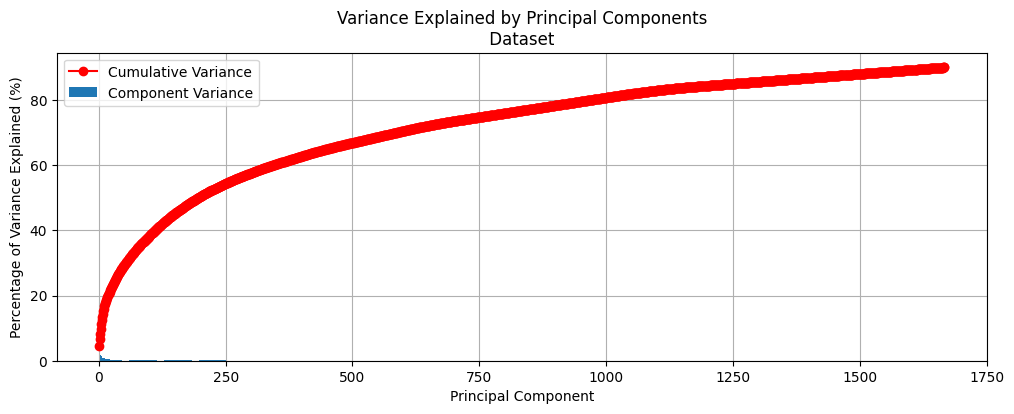

x_train_data head <bound method NDFrame.head of          pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
0    -0.179396 -0.140451  0.012515 -0.025258  0.035060  0.019149 -0.007741   
1     0.914673  0.001761  0.006879  0.008571 -0.001995  0.007168 -0.026262   
2    -0.140059  0.168469 -0.181811  0.007456 -0.151495 -0.154507 -0.089838   
3    -0.056070  0.287212 -0.720025  0.070791 -0.549066 -0.814264  0.174562   
4    -0.179113 -0.146355  0.007680 -0.026014  0.036677  0.019113 -0.009375   
...        ...       ...       ...       ...       ...       ...       ...   
2795 -0.179969 -0.140980  0.012973 -0.025436  0.035281  0.019337 -0.007740   
2796 -0.178248 -0.139392  0.011598 -0.024902  0.034619  0.018773 -0.007742   
2797 -0.156300  0.175795 -0.203536  0.005019 -0.166996 -0.164931 -0.100863   
2798 -0.182036  0.368623  0.167067  0.047912 -0.193094 -0.039317 -0.034764   
2799 -0.175761 -0.145621  0.002062 -0.025099  0.035755  0.017546 -0.010472   

         pca_8 

Epoch:   0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0, 
                      Mean Generator Loss: 1.3407533168792725, 
                     Mean Discriminator Loss: 1.3928295969963074
                      Generator Loss: 1.341, 
                      Discriminators Loss: [D1 loss: 1.404 | D2 loss: 1.389 | D3 loss: 1.385                      Took 8.82291865348816 seconds. 


Epoch: 100, 
                      Mean Generator Loss: 1.0619600008029748, 
                     Mean Discriminator Loss: 0.7474557856780173
                      Generator Loss: 0.921, 
                      Discriminators Loss: [D1 loss: 0.597 | D2 loss: 0.291 | D3 loss: 0.097                      Took 0.31104588508605957 seconds. 


Epoch: 200, 
                      Mean Generator Loss: 0.996559766987663, 
                     Mean Discriminator Loss: 0.4469177080001713
                      Generator Loss: 0.899, 
                      Discriminators Loss: [D1 loss: 0.064 | D2 loss: 0.008 | D3 loss: 0.002                      Took 0.32386350631713867 s

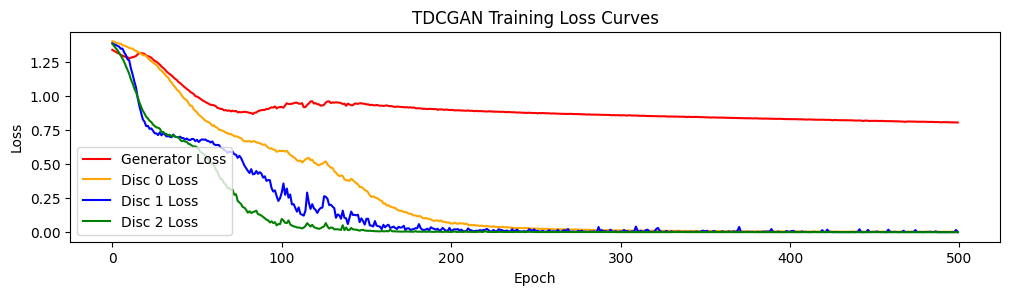

--- plot_3discs ---


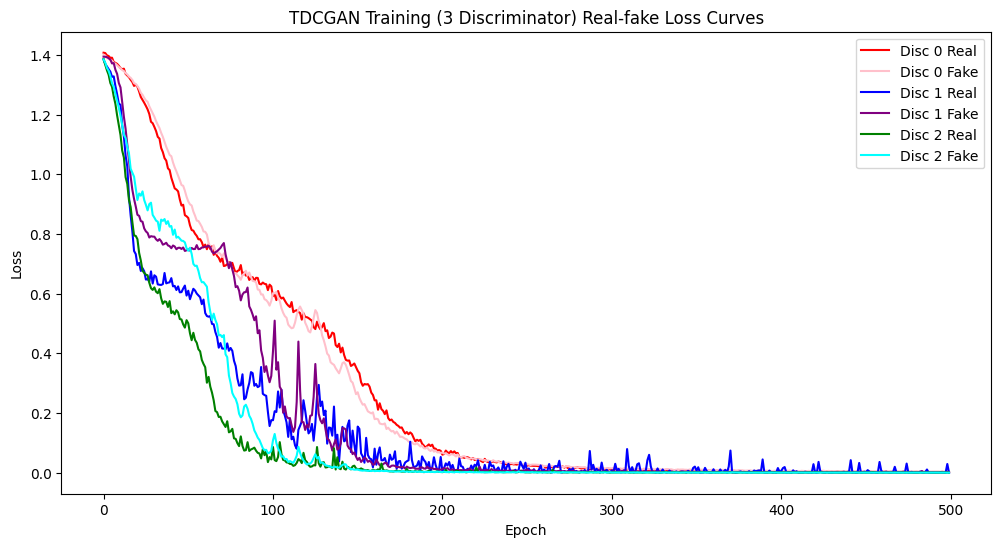

------------ Balance Data Using TDCGAN ------------
x_test_data shape :  (1200, 1667)
count features_test_cols:  1667
features_test_cols :  Index(['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8',
       'pca_9', 'pca_10',
       ...
       'pca_1658', 'pca_1659', 'pca_1660', 'pca_1661', 'pca_1662', 'pca_1663',
       'pca_1664', 'pca_1665', 'pca_1666', 'pca_1667'],
      dtype='object', length=1667)
labels_dic:  attack_type
1              611
0              589
Name: count, dtype: int64
max_class_sample:  611 
goal_rows_per_class:  611
num_samples_to_generate :  0
num_samples_to_generate :  22
We generate 22 synthetic samples for attack_type label (0,)
generated_data.shape:  (22, 1667)
labels_dic 2 len :  2
10
12
x_synthetic_data shape :  (22, 1667)
y_synthetic_data shape :  (22, 1)
x_synthetic_data head :  <bound method NDFrame.head of            pca_1         pca_2         pca_3         pca_4         pca_5  \
0   3.017001e-17  2.749760e-15  9.052362e-17  3.3317

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy:  0.8117839607201309
Mean Absolute Error: 0.18821603927986907
Precision: 0.8421414650922847
Recall: 0.8117839607201309
True Positives (TP): 587
True Negatives (TN): 405
False Positives (FP): 206
False Negatives (FN): 24
----- Boosting -----


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7970540098199672
Mean Absolute Error: 0.20294599018003273
Precision: 0.8431787587615467
Recall: 0.7970540098199672
True Positives (TP): 599
True Negatives (TN): 375
False Positives (FP): 236
False Negatives (FN): 12
----- Bagging -----


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.8216039279869067
Mean Absolute Error: 0.1783960720130933
Precision: 0.8552357113057989
Recall: 0.8216039279869067
True Positives (TP): 596
True Negatives (TN): 408
False Positives (FP): 203
False Negatives (FN): 15
----- Other Models -----

Evaluate models on dataset
1. Train and tune Decision Tree model
Training with the following parameters:
{'criterion': ['gini'], 'max_depth': [5], 'min_samples_split': [2], 'min_samples_leaf': [1]}
k_folds =  2
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   1.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   1.1s
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
k_folds =  2

X_test shape (1222, 1667)
y_test shape (1222, 1)
y_pred shape (1222,)
y_pred head [0 0 0 ... 1 1 1]
Decision Tree Model Classification Report 2:
 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.2s
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.2s
building tree 1 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
Best Parameters for Random Forest: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
k_folds =  2



<ipython-input-52-8664a55796de>:209: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_rf_model.fit(X_train, y_train)


X_test shape (1222, 1667)
y_test shape (1222, 1)
y_pred shape (1222,)
y_pred head [0 1 0 ... 1 1 1]
Random Forest Model Classification Report 2:
              precision    recall  f1-score   support

           0       0.93      0.29      0.44       611
           1       0.58      0.98      0.73       611

    accuracy                           0.63      1222
   macro avg       0.76      0.63      0.58      1222
weighted avg       0.76      0.63      0.58      1222

Accuracy:  0.6342062193126022
Mean Absolute Error: 0.3657937806873977
Precision: 0.7555181558547532
Recall: 0.6342062193126022
F1: 0.6895674017216125
True Positives (TP): 598
True Negatives (TN): 177
False Positives (FP): 434
False Negatives (FN): 13
4. Train and tune Naive Bayes model
X_test shape (1222, 1667)
y_test shape (1222, 1)
y_pred shape (1222,)
y_pred head [0 1 0 ... 1 1 1]
Naive Bayes Model Classification Report 2:


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.94      0.34      0.50       611
           1       0.60      0.98      0.74       611

    accuracy                           0.66      1222
   macro avg       0.77      0.66      0.62      1222
weighted avg       0.77      0.66      0.62      1222

Accuracy:  0.6612111292962357
Mean Absolute Error: 0.33878887070376434
Precision: 0.7701513172365191
Recall: 0.6612111292962357
F1: 0.7115355351573969
True Positives (TP): 598
True Negatives (TN): 210
False Positives (FP): 401
False Negatives (FN): 13
3. Train and tune MLP model
Training with the following parameters:
{'hidden_layer_sizes': [(10,)], 'activation': ['relu'], 'solver': ['adam'], 'alpha': [0.0001], 'max_iter': [10]}
k_folds =  2

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Iteration 1, loss = 0.69058132
Iteration 2, loss = 0.67878785


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 3, loss = 0.66818128
Iteration 4, loss = 0.65727478
Iteration 5, loss = 0.64566426
Iteration 6, loss = 0.63327969
Iteration 7, loss = 0.61998225
Iteration 8, loss = 0.60585613
Iteration 9, loss = 0.59064108
Iteration 10, loss = 0.57468633


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), max_iter=10, solver=adam; total time=   0.7s
Iteration 1, loss = 0.71785199
Iteration 2, loss = 0.70381104
Iteration 3, loss = 0.69184233
Iteration 4, loss = 0.68063270
Iteration 5, loss = 0.66920385
Iteration 6, loss = 0.65726332
Iteration 7, loss = 0.64497685
Iteration 8, loss = 0.63215454
Iteration 9, loss = 0.61889786
Iteration 10, loss = 0.60503473


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), max_iter=10, solver=adam; total time=   0.7s
Iteration 1, loss = 0.71786480
Iteration 2, loss = 0.70263817
Iteration 3, loss = 0.68896308
Iteration 4, loss = 0.67314710
Iteration 5, loss = 0.65499134
Iteration 6, loss = 0.63375085
Iteration 7, loss = 0.61045355
Iteration 8, loss = 0.58518586
Iteration 9, loss = 0.55655642
Iteration 10, loss = 0.52533758
Best Parameters for MLP: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'max_iter': 10, 'solver': 'adam'}
k_folds =  2



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_test shape (1222, 1667)
y_test shape (1222, 1)
y_pred shape (1222,)
y_pred head [0 0 0 ... 0 0 0]
MLP Model Classification Report 2:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       611
           1       0.98      0.97      0.98       611

    accuracy                           0.98      1222
   macro avg       0.98      0.98      0.98      1222
weighted avg       0.98      0.98      0.98      1222

Accuracy:  0.9787234042553191
Mean Absolute Error: 0.02127659574468085
Precision: 0.9787695728464847
Recall: 0.9787234042553191
F1: 0.9787464880064457
True Positives (TP): 595
True Negatives (TN): 601
False Positives (FP): 10
False Negatives (FN): 16


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:


# ---------------------------> Read Data of CSV Files <--------------------------- #
dataset_directory = "/content/datasets"   #files_path
percent = 100
data = read_csv_files(dataset_directory,percent)
print('len data : ' , len(data))

class_Col = 'attack_type'
min_rows_per_class = 2000  #50000
origin_data = data
#n_components = 0.95

# >> ---------------------------> Balance Data Before Start <--------------------------- #
#df_balanced_before = balance_data_before_tdcgan(data, class_Col, min_rows_per_class)
#data = df_balanced_before


# ---------------------------> Apply pre-processing <--------------------------- #
main_text_col = 'sentence'
n_classes, x_train_data, x_test_data, y_train, y_test, origin_x_train, origin_x_test, y_datatype = load_and_preprocess_data1(data)        ## pre-process way 2
num_classes = n_classes
print('-- End pre-process --')


# ---------------------------> Run TDCGAN Models (Gen., Disc., Comb.) - run_TDCGAN_models(old) <--------------------------- #
input_dim = x_train_data.shape[1]     # (features_dim) Dimensionality of TF-IDF vectors
print('features_dim shape: ', input_dim)

## Build the generator
#print('G input_dim: ', input_dim)
generator_model = build_generator(input_dim, num_classes)   # random_noise_size / input_shape / input_dim

## Build multiple discriminators (3 disc.)
discriminators_model = []
discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_0', 3, [100, 100, 100], 0.1))
discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_1', 5, [64, 128, 256, 512, 1024], 0.4))
discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_2', 4, [512, 256, 128, 64], 0.2))

## Build the combined model (GAN Model)
combined_model = build_combined_model(input_dim, num_classes, generator_model, discriminators_model)



# ---------------------------> print_models_summary <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")

## Generator Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (TDCGAN): \n{TextStyle.RESET_ALL}")
generator_model.summary(show_trainable=True,expand_nested=True)   #generator_model.summary()

## Discriminators Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nDiscriminators summary (TDCGAN): \n{TextStyle.RESET_ALL}")
i = 1
for discriminator in discriminators_model:
    print(f"{TextStyle.BOLD}\nDiscriminator " , i , f" summary (TDCGAN):{TextStyle.RESET_ALL} ")
    discriminator.summary(show_trainable=True,expand_nested=True)
    i = i + 1

## Combined Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (TDCGAN):\n{TextStyle.RESET_ALL} ")
combined_model.summary(show_trainable=True)



# ---------------------------> Train Model <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ train_model ------------{TextStyle.RESET_ALL}")
batch_size = BATCH_SIZE       # 128
noise_dim = input_dim
one_hot_encoder = train_model(BATCH_SIZE, noise_dim, num_classes, generator_model, discriminators_model, combined_model,
                      x_train_data, y_train, NUM_EPOCHS)



# >> ---------------------------> Balance Data Using TDCGAN <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Balance Data Using TDCGAN ------------{TextStyle.RESET_ALL}")

goal_rows_per_class = 1000
features_test_cols = x_test_data.columns
print('x_test_data shape : ', x_test_data.shape)
print('count features_test_cols: ', len(features_test_cols))
print('features_test_cols : ' , features_test_cols)

x_synthetic_data, y_synthetic_data, synthetic_data = balance_data_using_tdcgan(y_test, input_dim, features_test_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class)


# add colum clear instance is real data or fake to help compare in evaluate step
# can't assume all real (1) m because we add new synthetic_data (fake) to them
y_test['is_real'] = np.ones(y_test.shape[0])
print('y_test.shape[0] : ', y_test.shape[0])

y_synthetic_data['is_real'] = np.zeros(y_synthetic_data.shape[0])


# Concatenate synthetic samples with the original dataset
new_x_test_data = pd.concat([x_test_data, x_synthetic_data], ignore_index=True, sort=False)
new_y_test_data = pd.concat([y_test, y_synthetic_data], ignore_index=True, sort=False)
print('new_x_test_data shape : ' , new_x_test_data.shape)
print('new_y_test_data shape : ' , new_y_test_data.shape)
print('new_x_test_data : ' , new_x_test_data)
print('new_y_test_data : ' , new_y_test_data)


print('x_test_data shape : ' , x_test_data.shape)
print('y_test shape : ' , y_test.shape)

print('x_synthetic_data shape : ' , x_synthetic_data.shape)
print('y_synthetic_data shape : ' , y_synthetic_data.shape)



# ---------------------------> Evaluate Model <--------------------------- #
#evaluate_tdcgan(x_test_data, y_test, n_classes, batch_size, one_hot_encoder)  #, encoder)
evaluate_tdcgan(new_x_test_data, new_y_test_data, n_classes, batch_size, one_hot_encoder, y_datatype)  #, encoder)


# ---------------------------> Evaluate Other Models <--------------------------- #
#other_models_performance(x_train_data, x_test_data, y_train, y_test)
other_models_performance(x_train_data, new_x_test_data, y_train, new_y_test_data, one_hot_encoder)




# **CGAN**

### **CGAN Pre-process**

In [ ]:

def load_and_preprocess_data1(df_data):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Pre-Proccess Data ------------{TextStyle.RESET_ALL}")

    # ----------- Check for NaN Values ------------- #
    print("Checking for NaN vallues ...")
    if df_data.isnull().values.any():
        print("NaN values found in the dataset. Handling missing values...")
        # Handling missing values by imputing with mean (you can choose other methods as well)
        df_data = df_data.fillna(df_data.mean())
    df_data.replace([np.inf, -np.inf,np.nan,np.NAN],0, inplace=True)

    if df_data.isnull().sum().sum() == 0 : # and np.isinf(df_data.values).sum() == 0 :
        print('Done Handling missing values')


    # ----------- lowercase + strip 'sentence' ------------- #
    # Convert to lowercase & Remove spaces in start and end
    df_data['sentence'] = df_data['sentence'].str.lower().str.strip()


    # ------------------------------------  separate target from predictors ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- separate target from predictors -------{TextStyle.RESET_ALL}")

    # Step 1 : define targent column name and no. class in it
    class_Col = 'attack_type'
    n_classes = df_data[class_Col].nunique()      # no. classes/category in class_Col (attack_type)     n_classes = pd_frames['attack_type'].nunique()

    # Step 2: define datatype for columns
    df_data['len_payload'] = df_data['len_payload'].astype(int)


    if df_data[class_Col].dtype == 'object' :
        y_datatype = 'object'
        # Step 3: Convert Target Column 'attack_type'
        # 3.1 : Convert the 'attack_type' column to One-hot encode
        #encoder = OneHotEncoder(sparse=False)
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_attack_type = encoder.fit_transform(df_data[[class_Col]])
        encoded_attack_type_df = pd.DataFrame(encoded_attack_type, columns=encoder.get_feature_names_out([class_Col]))

        # 3.2 : Concatenate the encoded attack_type with the original DataFrame
        df_data = pd.concat([df_data.drop(class_Col, axis=1), encoded_attack_type_df], axis=1)
        df_data1_copy = df_data.copy()

        # Step 4: Identify the feature columns (X) and the target columns (y)
        # Assuming the target columns are all the one-hot encoded columns (with 'attack_type_' prefix)
        # Automatically find the target columns based on the columns added during encoding
        target_columns = [col for col in df_data.columns if col.startswith('attack_type_')]

        # Features are all the other columns
        feature_columns = [col for col in df_data.columns if col not in target_columns]

        df_data1 = df_data[feature_columns]
        y = df_data[target_columns]
        X = df_data1

    else:
        y_datatype = 'int'
        df_data[class_Col] = df_data[class_Col].astype(int)     #pd_frames['attack_type'] = pd_frames['attack_type'].astype(int)
        y = df_data[class_Col]      # main col to classify at end (class_Col --> attack_type)

        # remove y column (class_Col) from data columns list
        df_data1 = df_data.copy()
        df_data1.drop(columns=[class_Col], inplace=True)         #X.drop([class_Col], axis=1, inplace=True)
        #X_columns = df_data1.columns       #['sentence', 'len_payload', ....]
        X = df_data1


    print('X : ' , X)
    print('y: ', y)
    #print('y cols: ', y.columns)
    #y_columns = [col for col in y.columns]
    #print('y_columns: ', y_columns)



    # ------------------------------------ Apply encoding for categorical columns if any ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Handling Categorical Features -------{TextStyle.RESET_ALL}")

    # all categorical columns (any column with object dataType ant its value not number)
    categorical_cols = [cname for cname in X.columns if
                        X[cname].dtype == "object"]
    print("Categorical columns len: ", len(categorical_cols))
    print("Categorical columns: ", categorical_cols)

    # Columns that will be one-hot encoded
    # X[cname].nunique() < 4   : less that 4 categories in the column
    one_hot_cols = [cname for cname in X.columns if
                      X[cname].nunique() < 4 and
                      X[cname].dtype == "object"]
    print('one_hot_cols : ', one_hot_cols)
    print("No. Columns need to encoded using one-hot-encoding: ", len(one_hot_cols))

    # Skip this columns because it needs to use TfidFVectorizer With it
    skip_cols = [main_text_col]

    # Columns that will be target encoded  (will get columns with more than 4 categories in it :: like 'sentence' column)
    target_encode_cols = list(set(categorical_cols)-set(one_hot_cols) - set(skip_cols) )
    print('target_encode_cols : ', target_encode_cols)
    print("No. Columns need to encoded using target-encoding: ", len(target_encode_cols))


    # Encode categorical columns if there is any
    if(len(categorical_cols) > 0):

      # to perform one-hot encoding on specified columns of a DataFrame.
      if(len(one_hot_cols)> 0):
        X = one_hot_encoder_func(X, one_hot_cols)

      if(len(target_encode_cols) > 0):
        target_column = class_Col
        X = target_encode(X, y, target_encode_cols, target_column)

    else:
      print("No categorical columns, nothing todo")




    # ------------------------------------ train_test_split ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Divide the dataset into training (70%) and testing (30%) -------{TextStyle.RESET_ALL}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("Training data:\n")
    print("X_train : \n", X_train , '\n')
    print("y_train : \n", y_train)

    if y_datatype == 'int':
        y_train = pd.DataFrame(y_train, columns=[class_Col])        #'attack_type'
        y_test  = pd.DataFrame(y_test,  columns=[class_Col])

    print(f"Training rows (70% of Dataset)", "X_train shape: " , X_train.shape , " -- y_train shape: ", y_train.shape)
    print(f"Testing rows (30% of Dataset)", "X_test shape: " , X_test.shape , " -- y_test shape: ", y_test.shape)

    print('X_train head: ', X_train.head)
    print('y_train head: ', y_train.head)

    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    origin_x_train = X_train
    origin_x_test = X_test



    # ------------------------------------ Tokenization ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Tokenization -------{TextStyle.RESET_ALL}")

    X_train_tokenized = tokenization_text(X_train['sentence'], 'x_train')
    X_test_tokenized = tokenization_text(X_test['sentence'], 'x_test')

    # Join tokens back into strings for each sentence
    X_train_joined_sentences = [' '.join(tokens) for tokens in X_train_tokenized]     #X_train_copy['sentence_joined'] = ' '.join(X_train_tokenized)
    X_test_joined_sentences = [' '.join(tokens) for tokens in X_test_tokenized]
    #/print('joined_sentences: ' , joined_sentences)



    # ------------------------------------ TfidfVectorizer ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- TfidfVectorizer -------{TextStyle.RESET_ALL}")
    tfidf_vectorizer = TfidfVectorizer(dtype='float32')

    ## X_train
    #X_tfidf_values = tfidf_vectorizer.fit_transform(X_train['sentence'])      # without Tokenization step
    X_tfidf_values = tfidf_vectorizer.fit_transform(X_train_joined_sentences)      # With Tokenization Step

    X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()

    df_x_train = X_train.copy()
    df_x_train.drop(columns=['sentence'], inplace=True)
    df_tfidf_x_train = pd.DataFrame(X_tfidf_values.toarray(), columns=X_tfidf_selected_features)

    # Concatenate TF-IDF features with the original data excluding the sentence column
    x_train_data = pd.concat([df_x_train, df_tfidf_x_train], axis=1)


    ## X_test
    #X_test_tfidf_values = tfidf_vectorizer.transform(X_test['sentence'])      # without Tokenization step
    X_test_tfidf_values = tfidf_vectorizer.transform(X_test_joined_sentences)       # With Tokenization Step

    X_test_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()

    df_x_test = X_test.copy()
    df_x_test.drop(columns=['sentence'], inplace=True)
    df_tfidf_x_test = pd.DataFrame(X_test_tfidf_values.toarray(), columns=X_test_tfidf_selected_features)

    # Concatenate TF-IDF features with the original data excluding the sentence column
    x_test_data = pd.concat([df_x_test, df_tfidf_x_test], axis=1)
    print('end tfidf')



    # ------------------------------------ MinMaxScaler ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Scaling Features using 'MinMaxScaler' -------{TextStyle.RESET_ALL}")
    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(x_train_data)     #, axis=1)
    X_test_scaled = scaler.transform(x_test_data)           #, axis=1)

    # Convert the scaled numerical features back to DataFrames
    x_train_data = pd.DataFrame(X_train_scaled, columns=x_train_data.columns)     #X_train_scaled_df
    x_test_data = pd.DataFrame(X_test_scaled, columns=x_test_data.columns)        #X_test_scaled_df



    # ------------------------------------ PCA for feature selection ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- PCA for feature selection -------{TextStyle.RESET_ALL}")

    n_components = 0.90   #0.95
    pca = PCA(n_components=n_components, random_state=453)
    #print('pca: ' , pca)


    ## ------>> X_train << ------ ##
    print('pca x_train data')
    # Fit & Transform PCA on the training data
    X_train_pca = pca.fit_transform(x_train_data)

    # Convert PCA results back to DataFrames and concatenate with the original non-sentence columns
    # Generate new feature names for PCA components
    train_pca_feature_names = [f'pca_{i+1}' for i in range(X_train_pca.shape[1])]
    X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=train_pca_feature_names)      # Create a DataFrame with the PCA-transformed data
    x_train_data = X_train_pca_df
    print('end x_train_data')


    ## ------>> X_test << ------ ##
    print('pca x_test data')
    X_test_pca = pca.transform(x_test_data)
    test_pca_feature_names = [f'pca_{i+1}' for i in range(X_test_pca.shape[1])]
    X_test_pca_df = pd.DataFrame(data=X_test_pca, columns=test_pca_feature_names)
    x_test_data = X_test_pca_df
    print('end x_test_data')



    # variance ratio : show how much information (variance) can be attributed to each of the principal components.
    # Calculate explained variance ratio and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance      = np.cumsum(explained_variance_ratio)    # Calculates the cumulative explained variance ratio for each component.
    #print('explained_variance_ratio: ', explained_variance_ratio)
    #print('cumulative_variance: ', cumulative_variance)


    # Plot component variance and cumulative variance
    plt.figure(figsize=(12, 4))
    colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']

    # Plot component variance with percentages
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, label='Component Variance')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', color='r', label='Cumulative Variance')

    plt.title('Variance Explained by Principal Components\n Dataset ')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of Variance Explained (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


    """
    # Combine the PCA-transformed features with the target variable
    print('pca concat')
    x_train_data = pd.concat([X_train_pca_df, y_train], axis=1)
    print('pca concat - end x_train_data')
    x_test_data  = pd.concat([X_test_pca_df, y_test], axis=1)
    print('pca concat - end x_test_data')
    """

    print('x_train_data head', x_train_data.head)
    print('X_train_pca_df shape: ', x_train_data.shape)
    print('x_test_data shape: ', x_test_data.shape)


    return n_classes, x_train_data, x_test_data, y_train, y_test, origin_x_train, origin_x_test , y_datatype



## **Implement TDCGAN Models**

### **build_generator**

In [ ]:

def build_generator(input_dim, num_classes):   # vocabulary_size / num_class
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_generator ------------{TextStyle.RESET_ALL}")

  GENERATOR_DROPOUT_RATE = 0.2

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  noise = Input(shape=(input_dim,), name='noise')    # latent space noise (Features , ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')  # no need for One-hot encoded label, its numeric
  print('len noise: ', noise.shape[1])

  #concatenated = Concatenate()([data, label])
  # Concatenate features and label  (Concatenate along the last dimension)
  """  Concatenation: A Concatenate layer is used to combine the features and label along the last dimension (axis=-1).
      This creates a single input for the subsequent hidden layers in the discriminator model."""
  concatenated = Concatenate()([noise, label])   #Concatenate(axis=-1) is defualt

  # Embedded layer to map noise to lower-dimensional space
  # It creates a vector representation for the generated point.
  hidden = Embedding(input_dim, num_classes // 2)(concatenated)  # Adjust embedding dim as needed

  # Hidden layers with ReLU activation and dropout
  hidden = Dense(256, activation='relu')(concatenated)  #(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(128, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(64, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(32, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  # Output layer with Softmax activation
  generated_text = Dense(input_dim, activation='softmax', name='generated_text')(hidden)
  print('generated_text shape: ', generated_text.shape)

  # Create the generator model
  generator_model = Model(inputs=[noise, label], outputs=generated_text, name='generator')

  generator_model.compile(
      loss='categorical_crossentropy', #'binary_crossentropy',
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics=['accuracy']
  )

  return generator_model

### **build_discriminator**

In [ ]:

def build_discriminator(input_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_discriminator (", name , f") ------------{TextStyle.RESET_ALL}")

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  data  = Input(shape=(input_dim,), name='data')       # Features    (ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')   # Tf-IDF Vectorizer not One-hot encoded label
  print('len data: ', data.shape[1])
  # Concatenate features and label  (Concatenate along the last dimension)
  """  Concatenation: A Concatenate layer is used to combine the features and label along the last dimension (axis=-1).
      This creates a single input for the subsequent hidden layers in the discriminator model."""
  concatenated = Concatenate()([data, label])   #Concatenate(axis=-1) is defualt

  # Hidden layers with LeakyReLU activation and dropout
  # These layers extract the features
  hidden = data
  for i in range(num_hidden_layers):
    if i == 0:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(concatenated)
      hidden = Dense(neurons_per_layer[i])(concatenated)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
    else:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(hidden)   ##negative_slope  === alpha
      hidden = Dense(neurons_per_layer[i])(hidden)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
      # Consider adding for training stability (important) but this will make disc summary non-trainable params != 0
      #hidden = BatchNormalization()(hidden)

  ## Flatten ?!

  # Output layer for real vs fake prediction (Real/fake classification)
  validity_output = Dense(1, activation='sigmoid', name='validity_output')(hidden)

  # Output layer for class label prediction (normal/sqli attack classification)   (Auxiliary classification / class_output)
  auxiliary_output = Dense(num_classes, activation='softmax', name='auxiliary_output')(hidden)

  print('ttsm - real/fake validity_output : ', validity_output)
  print('ttsm - normal/sqli auxiliary_output : ', auxiliary_output)
  #print('ttsm - real/fake validity_output value : ', K.print_tensor(validity_output, message='K1 = '))
  #print('ttsm - normal/sqli auxiliary_output value : ', K.print_tensor(auxiliary_output, message='K2 = '))

  # Build and compile the discriminator model
  discriminator_model = Model(inputs=[data, label], outputs=[auxiliary_output, validity_output], name=name)    # inputs=data

  # auxiliary_output (attack_type maybe) may binary_crossentropy  (0 --> normal / 1 --> SQLi)
  #'auxiliary_output': 'categorical_crossentropy', // binary_crossentropy
  discriminator_model.compile(
      loss={'auxiliary_output': 'categorical_crossentropy', 'validity_output': 'binary_crossentropy'},
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics={'auxiliary_output': 'accuracy', 'validity_output': 'accuracy'})

  return discriminator_model


### **create_combined_model**

In [ ]:

def build_combined_model(input_dim, num_classes, generator_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_combined_model ------------{TextStyle.RESET_ALL}")

    print('comb 0')
    # functional API model has its input shape, it is suited for more complex models, accepting branches, concatenations, etc.
    #noise = Input(shape=(input_dim,))
    noise_data  = Input(shape=(input_dim,), name='noise_data')
    labels = Input(shape=(num_classes,), name='labels')
    print('labels sm : ', labels)

    # Generator output features for the discriminator
    generated_data = generator_model([noise_data, labels])      # generated_features

    print('comb 1')
    # Define list for Discriminator outputs for the generated data
    discriminators_class_outputs =[]
    discriminators_validity_outputs =[]

    """ With loop (num of Disc. (3 Disc)  ) """
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    for discriminator in discriminators_model:
        # Freeze discriminator
        # (Freeze Trainable Parameters) -> this make lots params non-trainable
        # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
        discriminator.trainable = False

    """
        ## Why Lists and not Concatenate Directly?
        ## Concatenating directly within the loop might lead to issues if the discriminators have
        ## slightly different output shapes (e.g., due to variations in architecture).
    """
    # another way (not in loop) see -->  ##### Comment 1 #####
    for discriminator in discriminators_model:
        # Discriminator Output for (class label prediction) and (validity --> real vs fake prediction)
        class_outputs , validity_outputs = discriminator([generated_data, labels])
        ##$$$$$$$class_outputs , validity_outputs = discriminator.predict([generated_data, labels])
        discriminators_class_outputs.append(class_outputs)
        discriminators_validity_outputs.append(validity_outputs)



    discriminators_outputs = {
                                'class': discriminators_class_outputs,
                                'validity': discriminators_validity_outputs
                            }


    # discriminators_outputs[class][0]  => discriminator 0 , [1] disc 1 , [2] disc 2
    print('comb 2')
    print('shap disc class output discriminators_outputs[class]: ', discriminators_outputs['class'] )
    print('shap disc validity output discriminators_outputs[validity]: ', discriminators_outputs['validity'] )
    print('shap disc class output discriminators_outputs[class][0]: ', discriminators_outputs['class'][0] )
    print('shap disc class output: ', discriminators_outputs['class'][0].shape[-1] )

    print('discriminators_outputs : ', discriminators_outputs)



    print('comb 3')
    # Concatenate discriminators outputs
    concatenated_discriminator_class_outputs = Concatenate()(discriminators_class_outputs)
    concatenated_discriminator_validity_outputs = Concatenate()(discriminators_validity_outputs)


    print('comb 4')
    # Output for class label prediction
    class_output = Dense(num_classes, activation='softmax', name='comb_class_output')(concatenated_discriminator_class_outputs)   #e_class_output)

    # Output for real vs fake prediction
    validity_output = Dense(1, activation='sigmoid', name='comb_validity_output')(concatenated_discriminator_validity_outputs)    #e_validity_output)


    print('comb 5')
    # Build the combined model
    combined_model = Model(inputs=[noise_data, labels],outputs=[class_output,validity_output], name='Combined_Model_TDCGAN')
    print('comb 6')

    combined_model.compile(
        loss={'comb_class_output': 'categorical_crossentropy', 'comb_validity_output': 'binary_crossentropy'},  # categorical_crossentropy
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5),
        metrics={'comb_class_output': 'accuracy', 'comb_validity_output': 'accuracy'}  #['accuracy']  #
    )
    print(77)

    return combined_model


### **print_models_summary**

In [ ]:
def print_models_summary(generator_model, combined_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (CGAN): \n{TextStyle.RESET_ALL}")
    generator_model.summary(show_trainable=True,expand_nested=True)

    i = 1
    for discriminator in discriminators_model:
        print(f"{TextStyle.BOLD}\nDiscriminator " , i , f" summary (CGAN): \n{TextStyle.RESET_ALL} ")
        discriminator.summary(show_trainable=True,expand_nested=True)
        i = i + 1


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (TDCGAN):\n{TextStyle.RESET_ALL} ")
    combined_model.summary(show_trainable=True)


## **Train CGAN**

In [ ]:
import time

# input_dim = latent_dim = noise_dim

def train_cgan(batch_size, noise_dim, num_classes, generator_model, discriminators_model, combined_model,
          X_train, y_train, NUM_EPOCHS):

  #X_train = np.array(X_train)  #.values.tolist()   #.toarray()  #to_numpy()   #csr_matrix.toarray
  #y_train = np.array(y_train)   #.values.tolist()   #.toarray()  #to_numpy()

  X_train = X_train.to_numpy()
  y_train = y_train.to_numpy()
  #print(y_train.head)

  # Save losses for plotting
  d0_real_losses = []   # left discriminator losses   (disc 0)
  d0_fake_losses = []   # left discriminator losses   (disc 0)
  d0_losses      = []   # discriminator losses        (disc 0)
  """d1_real_losses = []   # Middle discriminator losses (disc 1)
  d1_fake_losses = []   # Middle discriminator losses (disc 1)
  d1_losses      = []   # discriminator losses        (disc 1)
  d2_real_losses = []   # right discriminator losses  (disc 2)
  d2_fake_losses = []   # right discriminator losses  (disc 2)
  d2_losses      = []   # discriminator losses        (disc 2)"""
  g_losses       = []   # generator losses
  d_losses       = []   # discriminator losses

  #$valid = np.ones((batch_size, 1))  #tf.ones((batch_size, 1), dtype=tf.float32)
  #$fake  = np.zeros((batch_size, 1))  #tf.zeros((batch_size, 1), dtype=tf.float32)

  # -----------> Epochs <---------- #
  for epoch in tqdm(range(NUM_EPOCHS), desc="Epoch", unit="epoch"):
      d_loss_list = []
      g_loss_list = []
      start = time.time()

      #print(1)
      # Get a batch of real data
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      real_data   = X_train[idx]
      real_labels = y_train[idx]

      #print(2)
      # Ensure real_labels has the correct shape
      one_hot_encoder = OneHotEncoder(sparse_output=False)
      one_hot_labels = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
      real_labels = one_hot_labels[idx]
      #print('len one-hot real_labels: ', len(real_labels))        #128
      #print('len one-hot real_labels 10: ', real_labels[:10])       # [ [1. 0.] [1. 0.] [0. 1.] .... ]

      #print(3)
      # Sample a random batch of noise
      noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      real_labels1 = real_labels #np.random.normal(0, 2,size=(batch_size, num_classes))
      #print('noise', noise[:10])
      #print('real_labels1', real_labels1[:10])

      #print('3 a')
      #print('noise shape: ', noise.shape)
      #print('real_labels1 shape: ', real_labels1.shape)
      # Generate fake data using the generator -- Generate a batch of fake data
      ##$generated_data = generator_model([noise, real_labels])    # more direct and convenient during training
      generated_data = generator_model.predict([noise, real_labels1], verbose='0')
      #print('3 b')




      # ---------------------
      #  Train Discriminator
      # ---------------------
      #print('4')
      valid = np.ones((batch_size, 1))  #tf.ones((batch_size, 1), dtype=tf.float32)
      fake  = np.zeros((batch_size, 1))  #tf.zeros((batch_size, 1), dtype=tf.float32)

      # -------->   Disc 0   <--------- #
      #print('4 disc 0')
      disc_loss_real_0 = discriminators_model[0].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_0 = discriminators_model[0].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_0 = 0.5 * np.add(disc_loss_real_0, disc_loss_fake_0)   #take average loss from real and fake images.

      """
      # -------->   Disc 1   <--------- #
      #print('4 disc 1')
      disc_loss_real_1 = discriminators_model[1].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_1 = discriminators_model[1].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_1 = 0.5 * np.add(disc_loss_real_1, disc_loss_fake_1)   #take average loss from real and fake images.

      # -------->   Disc 2   <--------- #
      #print('4 disc 2')
      disc_loss_real_2 = discriminators_model[2].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_2 = discriminators_model[2].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_2 = 0.5 * np.add(disc_loss_real_2, disc_loss_fake_2)   #take average loss from real and fake images.
      """

      d0_real_losses.append(disc_loss_real_0)
      #d1_real_losses.append(disc_loss_real_1)
      #d2_real_losses.append(disc_loss_real_2)

      d0_fake_losses.append(disc_loss_fake_0)
      #d1_fake_losses.append(disc_loss_fake_1)
      #d2_fake_losses.append(disc_loss_fake_2)

      d0_losses.append(d_loss_0)
      #d1_losses.append(d_loss_1)
      #d2_losses.append(d_loss_2)

      # ---------------------
      #  Train Generator
      # ---------------------
      #noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      g_loss = combined_model.train_on_batch([noise, real_labels1], [real_labels1, valid])
      g_losses.append(g_loss[0])



      # Print the loss every few epochs (Print progre)
      # can remove it & print epoch all time OR  at finish (epoch % 100)
      if epoch % 100 == 0 or epoch == NUM_EPOCHS:
          # try this --->  direct g_loss_list not np.mean(g_loss_list)
          #print (
          tqdm.write(f'{TextStyle.BOLD}{TextStyle.BLUE}Epoch: {epoch}, \n  \
                    Mean Generator Loss: {np.mean(g_losses)}, \n \
                    Mean Discriminator Loss: {np.mean(d0_losses)}\n  \
                    Generator Loss: {g_loss[0]:.3f}, \n  \
                    Discriminators Loss: [D1 loss: {d_loss_0:.3f}  \
                    {TextStyle.RESET_ALL}' ,end=''
                )
          print (f'Took {time.time()-start} seconds. \n\n')

  print('----- End Epoch : -----', )




  ## ------- Plot TDCGAN Training Losses Curves ------- ##
  print('--- plot_losses ---')
  # Define labels for each loss
  labels      = ['Generator Loss' , 'Disc 0 Loss', 'Disc 1 Loss', 'Disc 2 Loss' ]
  colors_list = ['Red'            , 'Orange'     , 'Blue'       , 'Green'       ]
  epochs = list(range(NUM_EPOCHS))

  plt.figure(num= 'normal_1', figsize=(12, 6))
  plt.subplot(2, 1, 1)

  plt.plot(epochs, g_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_losses, color=colors_list[1], label=labels[1])
  #plt.plot(epochs, d1_losses, color=colors_list[2], label=labels[2])
  #plt.plot(epochs, d2_losses, color=colors_list[3], label=labels[3])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('TDCGAN Training Loss Curves')
  plt.legend()
  #plt.grid(True)
  #plt.tight_layout()
  plt.show()

  # Optional: Save the plot as an image (empty content)
  #plt.savefig('tdcgan_losses.png')



  ## ------- Plot TDCGAN Training (3 Discriminator) Real-fake Loss Curves ------- ##
  print('--- plot_3discs ---')
  labels      = ['Disc 0 Real' , 'Disc 0 Fake',     'Disc 1 Real', 'Disc 1 Fake',     'Disc 2 Real', 'Disc 2 Fake']
  colors_list = ['Red'         , 'pink'       ,     'Blue'       , 'Purple'     ,     'Green'      ,  'Cyan' ]
  #colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']
  epochs = list(range(NUM_EPOCHS))

  #plt.figure()
  plt.figure(num= 'normal_21', figsize=(12, 6))
  #plt.subplot(2, 1, 2)

  plt.plot(epochs, d0_real_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_fake_losses, color=colors_list[1], label=labels[1])
  """plt.plot(epochs, d1_real_losses, color=colors_list[2], label=labels[2])
  plt.plot(epochs, d1_fake_losses, color=colors_list[3], label=labels[3])
  plt.plot(epochs, d2_real_losses, color=colors_list[4], label=labels[4])
  plt.plot(epochs, d2_fake_losses, color=colors_list[5], label=labels[5])"""

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('TDCGAN Training (3 Discriminator) Real-fake Loss Curves')
  plt.legend()
  plt.show()


  return one_hot_encoder




## **Balance using cgan**

### **Int target_column**

In [ ]:
def int_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype):
    noise_dim = input_dim
    categories = y_data[class_Col]       # without head column  used in balanced TDCGAN

    # Count ( # rows (instance)) the occurrences of each value in class_Col,  len(labels_dic) is equal to n_classes
    labels_dic = y_data.value_counts()     #class_counts    y_data = pd.Index([0,0,1,0,1], name ='attack_type')
    print('labels_dic: ', labels_dic)
    """
      ex res:
          class_counts :  attack_type
          1    3
          0    2
          Name: count, dtype: int64
    """

    # Generate synthetic features and labels
    synthetic_features = []
    synthetic_labels = []


    # Check if all values are equal
    is_samples_equal = True if labels_dic.nunique() == 1 else False

    # Updata goal_rows_per_class if it is less that the max no of label in labels_dic & keep them balanced
    max_class_sample = max(num_samples for label, num_samples in labels_dic.items())    #(major class)
    goal_rows_per_class = max_class_sample   #max(goal_rows_per_class, max_class_sample)
    #goal_rows_per_class = goal_rows_per_class + 2     # to add atleast 2 for the max num_sample
    print('max_class_sample: ' , max_class_sample , '\ngoal_rows_per_class: ', goal_rows_per_class)

    for label, num_samples in labels_dic.items():
        """ ex: label -- num_samples
                  1   --    3
                  0   --    5
        """
        #labels_dic[label]= majority_count - value    # labels_dic[label] same value

        # To balanced using
        if is_samples_equal == False:
            num_samples_to_generate = max_class_sample - num_samples
        else:
            num_samples_to_generate = max_class_sample/2

        #num_samples_to_generate = goal_rows_per_class + ( max_class_sample - num_samples )
        print('num_samples_to_generate : ', num_samples_to_generate)

        if num_samples_to_generate > 0:
            # Generate labels by repeating each unique label based on the specified number of samples
            print("We generate " + str(num_samples_to_generate) + " synthetic samples for attack_type label " + str(label))
            generated_labels = np.repeat(label, num_samples_to_generate).reshape(-1,1)
            encoded_labels = one_hot_encoder.transform(generated_labels)      ##$$ try in ecah one / try after concat all
            #print('generated_labels.shape : ', generated_labels.shape , ',  encoded_labels.shape : ', encoded_labels.shape)      # (1002, 1) ,  (1002, 2)
            #print('generated_labels : ', generated_labels)                  # [ [1] [1] [1] ... [1] [1] ]
            #print('encoded_labels : ', encoded_labels)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]

            # Generate random sample of noise for each class  (will use num_sample instead of batch_size that used in Train)
            noise = np.random.normal(0, 1,size=(num_samples_to_generate, noise_dim))
            #print('noise: ' , noise.shape)

            # Generate fake data using the generator -- Generate a batch of fake data
            ##$$generated_data = generator_model([noise, real_labels1])    # more direct and convenient during training
            generated_data = generator_model.predict([noise, encoded_labels], verbose='0')
            print('generated_data.shape: ', generated_data.shape)
            #print('generated_data: ', generated_data)

            synthetic_features.append(generated_data)
            synthetic_labels.append(generated_labels)
            #print('len synthetic_features: ' , synthetic_features.shap)
            #print('len synthetic_labels: ' , synthetic_labels.shap)

    print('labels_dic 2 len : ', len(labels_dic))           # 2


    ##$$encoded_labels = one_hot_encoder.transform(synthetic_labels)      ##$$ try in ecah one / try after concat all

    print('10')
    # Concatenate the generated features and labels
    synthetic_features = np.concatenate(synthetic_features)
    synthetic_labels = np.concatenate(synthetic_labels).reshape(-1, 1)

    print('12')
    # Create a DataFrame with synthetic features and labels
    x_synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    y_synthetic_data = pd.DataFrame(synthetic_labels, columns=[class_Col])

    print('x_synthetic_data shape : ' , x_synthetic_data.shape)
    print('y_synthetic_data shape : ' , y_synthetic_data.shape)
    print('x_synthetic_data head : ' , x_synthetic_data.head)
    print('y_synthetic_data head : ' , y_synthetic_data.head)

    synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    synthetic_data[class_Col] = synthetic_labels


    return x_synthetic_data, y_synthetic_data, synthetic_data

### **one_hot_encoder Target_column (obj)**

In [ ]:
def obj_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype):

    noise_dim = input_dim

    # Find y columns names
    #print('y cols: ', y_data.columns)
    y_columns = [col for col in y_data.columns]
    print('y_columns: ', y_columns)

    # Count the occurrences of each category (Count (# rows (instance)) the occurrences of each value in class_Col,  len(labels_dic) is equal to n_classes)
    # category_counts =  y_data.sum(axis=0)  #print('category_counts: ', category_counts)
    categories_counts = y_data.apply(lambda df_y: df_y.value_counts().get(1, 0))
    print("Count of value 1 in each column: ", categories_counts)

    # Check if all values are equal
    is_samples_equal = categories_counts.nunique() == 1
    print('is_samples_equal : ', is_samples_equal)

    labels_dic = y_data.value_counts()
    print('labels_dic: ', labels_dic)
    """
      ex res:
          class_counts :  attack_type_SQLi  attack_type_normal
          1.0               0.0                3
          0.0               1.0                2
          Name: count, dtype: int64
    """

    # Get the maximum value from the counts + Updata goal_rows_per_class if it is less that the max no of label in labels_dic & keep them balanced
    max_class_sample = categories_counts.max()
    goal_rows_per_class = max_class_sample
    print('max_class_sample: ' , max_class_sample , '\ngoal_rows_per_class: ', goal_rows_per_class)


    # Generate synthetic features and labels
    synthetic_features = []
    synthetic_labels = []

    for column in y_data.columns:
        additional_samples_needed = int(max_class_sample - categories_counts[column])     #goal_rows_per_class
        print('column: ', column , ' - additional_samples_needed: ' , additional_samples_needed)

        if additional_samples_needed > 0:

            # Step 1 : Generate new y samples count --> additional_samples_needed
            # Create a new instance with 0.0 for all columns and 1.0 for specific column
            new_instance = {col: 0.0 for col in y_data.columns}
            new_instance[column] = 1.0

            # Convert the new instance to a DataFrame
            new_instance_df = pd.DataFrame([new_instance])

            # Repeat the new instance DataFrame
            repeated_new_instances = pd.concat([new_instance_df] * additional_samples_needed, ignore_index=True)
            print('len repeated_new_instances : ', len(repeated_new_instances) )

            # Convert repeated_new_instances to numpy array
            repeated_new_instances_np = repeated_new_instances.to_numpy()

            #print('encoded_labels : ', encoded_labels)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]
            print('repeated_new_instances_np : ', repeated_new_instances_np)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]
            print('repeated_new_instances : ', repeated_new_instances)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]

            synthetic_labels.append(repeated_new_instances_np)
            #print('len synthetic_labels: ' , synthetic_labels.shap)


            print('step 2')
            # Step 2 : Generate random sample of noise for each class  (will use num_sample instead of batch_size that used in Train)
            noise = np.random.normal(0, 1,size=(additional_samples_needed, noise_dim))
            #print('noise: ' , noise.shape)
            print('step 2 - end noise')

            print('noise: ' , noise.shape)
            print('repeated_new_instances: ' , repeated_new_instances.shape)

            # Generate fake data using the generator -- Generate a batch of fake data
            generated_data = generator_model.predict([noise, repeated_new_instances_np], verbose='0')
            print('generated_data.shape: ', generated_data.shape)  # , ' /n generated_data: ', generated_data)

            synthetic_features.append(generated_data)
            #print('len synthetic_features: ' , synthetic_features.shap)


    print('9')
    synthetic_labels = repeated_new_instances

    print('10')
    # Concatenate the generated features and labels
    synthetic_features = np.concatenate(synthetic_features)
    #synthetic_labels = np.concatenate(synthetic_labels).reshape(-1, 1)


    print('12')
    # Create a DataFrame with synthetic features and labels
    x_synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    y_synthetic_data = pd.DataFrame(synthetic_labels, columns=y_columns)

    print('x_synthetic_data shape : ' , x_synthetic_data.shape)
    print('y_synthetic_data shape : ' , y_synthetic_data.shape)
    print('x_synthetic_data head : ' , x_synthetic_data.head)
    print('y_synthetic_data head : ' , y_synthetic_data.head)

    synthetic_data = pd.concat([x_synthetic_data, y_synthetic_data], ignore_index=True)

    #synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    #synthetic_data[class_Col] = synthetic_labels


    return x_synthetic_data, y_synthetic_data, synthetic_data

    # Append the repeated new instances to the original DataFrame
    #y_data = pd.concat([y_data, repeated_new_instances], ignore_index=True)


### **test**

In [ ]:
y_data = {
   'attack_type_SQLi': [0.0, 0.0, 1.0, 1.0, 1.0, 0.0],
   'attack_type_normal': [1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
   'attack_type_xss': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
}
df = pd.DataFrame(y_data)

# Count the number of occurrences of the value `1` in each column
categories_counts = df.apply(lambda x: x.value_counts().get(1, 0))
print("Count of value 1 in each column:")
print(categories_counts)

labels_dic = df.value_counts()
print('labels_dic: ', labels_dic)

# Check if all counts are equal
all_equal = categories_counts.nunique() == 1
print("All counts are equal:", all_equal)

# Get the maximum value from the counts
max_value = categories_counts.max()
print("Maximum value:", max_value)

labels_dic = categories_counts


for column in df.columns:
    additional_samples_needed = int(max_value - categories_counts[column])
    if additional_samples_needed > 0:
        # Create a new instance with 0.0 for all columns and 1.0 for specific column
        new_instance = {col: 0.0 for col in df.columns}
        new_instance[column] = 1.0

        # Convert the new instance to a DataFrame
        new_instance_df = pd.DataFrame([new_instance])

        # Repeat the new instance DataFrame
        repeated_new_instances = pd.concat([new_instance_df] * additional_samples_needed, ignore_index=True)
        print('len repeated_new_instances : ', len(repeated_new_instances) )

        # Append the repeated new instances to the original DataFrame
        df = pd.concat([df, repeated_new_instances], ignore_index=True)


# Shuffle the DataFrame to randomize the order
df = df.sample(frac=1).reset_index(drop=True)

print("Balanced DataFrame:")
print(df)



Count of value 1 in each column:
attack_type_SQLi      3
attack_type_normal    2
attack_type_xss       1
dtype: int64
labels_dic:  attack_type_SQLi  attack_type_normal  attack_type_xss
1.0               0.0                 0.0                3
0.0               1.0                 0.0                2
                  0.0                 1.0                1
Name: count, dtype: int64
All counts are equal: False
Maximum value: 3
len repeated_new_instances :  1
len repeated_new_instances :  2
Balanced DataFrame:
   attack_type_SQLi  attack_type_normal  attack_type_xss
0               0.0                 1.0              0.0
1               0.0                 0.0              1.0
2               0.0                 0.0              1.0
3               0.0                 1.0              0.0
4               1.0                 0.0              0.0
5               0.0                 1.0              0.0
6               0.0                 0.0              1.0
7               1.0        

### **Main Function**

In [ ]:
#goal_rows_per_class = 1000
def balance_data_using_cgan(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype):

    if y_datatype == 'object':
        x_synthetic_data, y_synthetic_data, synthetic_data = obj_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype)

    else:
        x_synthetic_data, y_synthetic_data, synthetic_data = int_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype)


    return x_synthetic_data, y_synthetic_data, synthetic_data


## **Evaluate CGAN**

In [ ]:

def evaluate_cgan(X_test, y_test, n_classes, batch_size, one_hot_encoder, y_datatype): ###$$$, encoder): #track 1
    # ---------------------------> X_test dataset in CGAN <--------------------------- #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ evaluate_cgan ------------{TextStyle.RESET_ALL}")
    #input_dim = X_test.shape[1]

    # get column is_real
    y_test_real = y_test['is_real']                        # .astype(int)
    y_test.drop(columns=['is_real'], inplace=True)         # remove is_real column from y_test columns list
    #print('y_test_real : ' , y_test_real)
    #print('y_test : ' , y_test)

    if y_datatype == 'object':
        y_test_n = y_test

    else:
        ##print('e2')
        # One-hot encode labels for evaluation
        one_hot_labels = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))
        y_test_n = one_hot_labels

    print('e3')

    # Evaluate the combined model on real data
    y_pred_combined_real = combined_model.predict([X_test, y_test_n])
    """
    y_pred_combined_real = [
        array(            ---> SQLi/normal   (predicted_labels_real)
              [
                  [0.6907744, 0.3092256],
                  [0.5507812, 0.4492188],
                  [0.4492188, 0.5507812],
              ], dtype=float32
        ),
        array(            --->  Real/Fake    (predicted_real_vs_fake_combined)
              [
                  [0.47635472],
                  [0.47627473],
                  [0.4762748 ],
              ], dtype=float32
        )
    ]
    """

    print('y_pred_combined_real[0] : ', y_pred_combined_real[0])
    print('predicted_labels_real : ', y_pred_combined_real[1])



    # ----------- For Class Prediction (SQLi / normal)  ------------- #
    print('e5')
    print('y_test_n : ' , y_test_n)

    # Convert y_true to 1-dimensional array where each item is the first value in [SQLi, normal] (Take the first column 'SQLi' of y_true)

    predicted_labels_real = y_pred_combined_real[0][:, 0]   #.astype(int)
    print('predicted_labels_real : ', predicted_labels_real)                # predicted_labels_real :  [0.6907744 0.5507812 0.4492188 ... ]  --> >= 0.5 SQli , <0.5 normal
    predicted_labels_real = np.round(predicted_labels_real)
    print('predicted_labels_real 1 : ', predicted_labels_real)

    y_test_n = np.array(y_test_n)     #    y_test_n = y_test_n.to_numpy()
    y_true = y_test_n[:, 0]                                   #.astype(int)   y_true_labels
    print('y_true : ' , y_true)

    #y_true_labels = np.argmax(y_test_n, axis=1)       # Convert y_true from one-hot encoded format to single column of class labels (take second column 'normal')
    #predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)

    """
    y_true = y_test_n --->
    attack_type_SQLi  attack_type_normal
          1.0                 0.0
          0.0                 1.0
          0.0                 1.0


    original_values = encoder.inverse_transform(y_pred_combined_real[0])
    """

    #y_true = encoder.inverse_transform(y_test_n)
    #predicted_labels_real = encoder.inverse_transform(y_pred_combined_real[0])

    #y_true = y_true.flatten()   # 1-dimension
    #predicted_labels_real = predicted_labels_real.flatten()   # 1-dimension
    #print('encoder.inverse_transform y_true : ' , y_true)
    #print('encoder.inverse_transform predicted_labels_real : ' , predicted_labels_real)


    # ----------- For Real vs. Fake Prediction (Real / Fake)  ------------- #
    print('e6')
    ##num_samples = len(X_test)
    ##y_test_real = np.ones(num_samples)


    print('e7')
    # Reshape predicted_real_vs_fake to match the shape of y_test_real (flatten() function converts it to a 1-dimensional array)
    predicted_real_vs_fake_combined = y_pred_combined_real[1]
    predicted_real_vs_fake = predicted_real_vs_fake_combined.flatten()   # 1-dimension
    predicted_real_vs_fake = np.round(predicted_real_vs_fake)

    # Real / Fake
    print('y_test_real : ' , y_test_real)                                       # y_test_real             : [1. 1. 1. ... 1. 1. 1.]
    print('predicted_real_vs_fake : ' , predicted_real_vs_fake)                 # predicted_real_vs_fake  : [[0.] [0.] [0.] ... [0.] [0.] [0.]]




    # ----------- Way 1 ------------- #
    ## way 1
    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 1 ------{TextStyle.RESET_ALL}")

    # Print the classification report for the combined model on real data
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    ###$$$print(classification_report(encoder.inverse_transform(y_test_n), encoder.inverse_transform(predicted_labels_real),zero_division=1))  # track 1
    print(classification_report(y_true, predicted_labels_real, zero_division=1))

    ##print('e7')
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(y_test_real, predicted_real_vs_fake,zero_division=1))


    # ----------- Way 2 ------------- #

    ## way 2
    from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 2 ------{TextStyle.RESET_ALL}")
    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    accuracy = accuracy_score(y_true, predicted_labels_real)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_true, predicted_labels_real)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_true, predicted_labels_real, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_true, predicted_labels_real, average='macro')
    print("Recall:", recall)
    f1 = 2 * ( (precision * recall) / (precision + recall) )
    print("F1:", f1)
    conf_matrix = confusion_matrix(y_true, predicted_labels_real)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    """
    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    y_testing = np.ones(num_samples)
    y_predection = np.round(predicted_real_vs_fake_combined)

    accuracy = accuracy_score(y_testing, y_predection)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_testing, y_predection)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_testing, y_predection, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_testing, y_predection, average='macro')
    print("Recall:", recall)
    """




    # ----------- Way 3 ------------- #
    """
    ## way 3
    Update discriminator metrics based on true labels and predicted labels.
    Parameters:
      - y_true: True labels (ground truth).   -->  y_test_n
      - y_pred: Predicted labels.             -->
    Returns:
      - metrics_dict: Dictionary containing updated discriminator metrics.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 3 ------{TextStyle.RESET_ALL}")

    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    metrics_dict = {}
    metrics_dict['accuracy']  = accuracy_score(y_true, predicted_labels_real)          # Calculate accuracy
    metrics_dict['precision'] = precision_score(y_true, predicted_labels_real)         # Calculate precision
    metrics_dict['recall']    = recall_score(y_true, predicted_labels_real)            # Calculate recall
    metrics_dict['f1']        = f1_score(y_true, predicted_labels_real)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict['accuracy']    )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict['precision']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict['recall']      )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict['f1']          )


    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    metrics_dict1 = {}
    metrics_dict1['accuracy']  = accuracy_score(y_test_real, predicted_real_vs_fake)          # Calculate accuracy
    metrics_dict1['precision'] = precision_score(y_test_real, predicted_real_vs_fake)         # Calculate precision
    metrics_dict1['recall']    = recall_score(y_test_real, predicted_real_vs_fake)            # Calculate recall
    metrics_dict1['f1']        = f1_score(y_test_real, predicted_real_vs_fake)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict1['accuracy']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict1['precision']  )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict1['recall']     )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict1['f1']         )




In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Example data
y_pred_combined_real = [
    np.array([
        [0.6907744, 0.3092256],
        [0.5507812, 0.4492188],
        [0.5507812, 0.4492188],
    ], dtype=np.float32),
    np.array([
        [0.47635472],
        [0.47627473],
        [0.4762748],
    ], dtype=np.float32)
]

y_true = np.array([
    [1.0, 0.0],
    [0.0, 1.0],
    [0.0, 1.0]
])

# Step 1: Convert y_true to 1-dimensional array where each item is the first value in [SQLi, normal] (Take the first column 'SQLi' of y_true)
y_true_labels = y_pred_combined_real[0][:, 0]

print('y_true_labels 2 : ' , y_true_labels)


xx = [ 0.47635472, 0.47627473, 0.4462748 ]
predicted_real_vs_fake = np.round(xx) #.astype(int)

#predicted_real_vs_fake = np.round(y_pred_combined_real[1])
print('predicted_real_vs_fake : ' , predicted_real_vs_fake)


#y_true_labels = np.argmax(y_true, axis=1)       # Step 1: Convert y_true from one-hot encoded format to single column of class labels (take second column 'normal')

#encoder = OneHotEncoder(sparse=False)
#encoded_attack_type = encoder.fit_transform(df[['attack_type']])
#original_values = encoder.inverse_transform(y_true)
#print('y_true_labels : ' , y_true_labels)


"""
from sklearn.preprocessing import LabelEncoder

encoder1 = LabelEncoder()
# Fit and transform the target column 'y'
y_encoded = encoder1.fit_transform(y_true)
print('y_encoded : ', y_encoded)
"""

y_true_labels 2 :  [0.6907744 0.5507812 0.5507812]
predicted_real_vs_fake :  [0. 0. 0.]


"\nfrom sklearn.preprocessing import LabelEncoder\n\nencoder1 = LabelEncoder()\n# Fit and transform the target column 'y'\ny_encoded = encoder1.fit_transform(y_true)\nprint('y_encoded : ', y_encoded)\n"

In [ ]:
import numpy as np

# Example data
y_true_labels = [0.6907744, 0.5507812, 0.307812]

# Use np.round() to round values according to the specified criteria
rounded_labels = np.round(y_true_labels)

# Print the rounded labels
print(rounded_labels)

[1. 1. 0.]


## **Run CGAN**

------------ Handling Read CSV Files ------------
Your files are:  ['before_only_4000.csv']
File Path:  /content/datasets/before_only_4000.csv
Total rows in df/file:  4000
Total rows in df/file 100%:  4000
                                               sentence  attack_type  \
2851                                           rainmake            0   
1755                                1%" and 2805 = 1345            1   
1250                   -3637" or  ( 8459 = 8459 ) *4906            1   
1608  1%"  )  )   or elt ( 6272 = 6272,sleep ( 5  ) ...            1   
2951  insert into product  ( product_cd, name, produ...            0   
...                                                 ...          ...   
2123                                            esteban            0   
3845  com/visual-art/pdf-14242-86-bed_and_breakfast_...            0   
3146                                       p41did3m31te            0   
854                           1" union all select null#            1   
13

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float32 'dtype' will be converted to np.float64.
  warnings.warn(


end tfidf
------- Scaling Features using 'MinMaxScaler' -------
------- PCA for feature selection -------
pca x_train data
end x_train_data
pca x_test data
end x_test_data


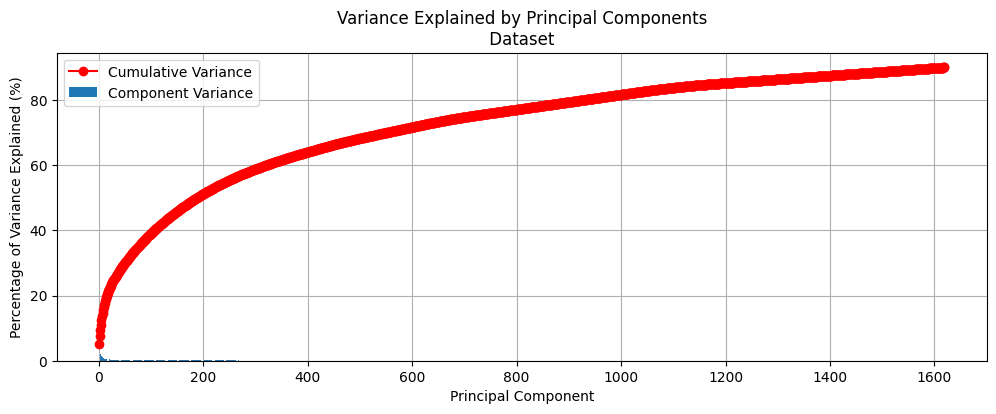

x_train_data head <bound method NDFrame.head of          pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
0    -0.210451 -0.122977 -0.043993 -0.001951  0.016225 -0.004147 -0.017646   
1    -0.222913 -0.110233 -0.016695 -0.020969  0.008089 -0.003448 -0.012833   
2    -0.136933 -0.061420 -0.068972  0.017438  0.018931  0.005179 -0.004728   
3     0.106782  0.138560 -0.165187  0.087279  0.034538  0.037280  0.044829   
4     0.140464  1.367533 -0.330894  0.339873  0.541733 -0.169997  0.235908   
...        ...       ...       ...       ...       ...       ...       ...   
2795 -0.239098 -0.144893 -0.033699 -0.008873  0.014702 -0.007260 -0.021827   
2796 -0.237607 -0.147062 -0.045921 -0.008018  0.020298 -0.006888 -0.028557   
2797 -0.188144 -0.102969 -0.053935  0.004448  0.017903 -0.000520 -0.012648   
2798 -0.237776 -0.143848 -0.034107 -0.008568  0.014748 -0.007119 -0.021613   
2799  1.017610 -0.056113  0.007237  0.021315 -0.007983  0.003920  0.006383   

         pca_8 

Epoch:   0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0, 
                      Mean Generator Loss: 1.2694242000579834, 
                     Mean Discriminator Loss: 1.390312910079956
                      Generator Loss: 1.269, 
                      Discriminators Loss: [D1 loss: 1.390                      Took 3.5501978397369385 seconds. 


Epoch: 100, 
                      Mean Generator Loss: 1.1294981819568295, 
                     Mean Discriminator Loss: 0.9523877303789158
                      Generator Loss: 1.022, 
                      Discriminators Loss: [D1 loss: 0.644                      Took 0.16042470932006836 seconds. 


Epoch: 200, 
                      Mean Generator Loss: 1.0700270773759528, 
                     Mean Discriminator Loss: 0.7484542552511491
                      Generator Loss: 1.009, 
                      Discriminators Loss: [D1 loss: 0.420                      Took 0.15886211395263672 seconds. 


Epoch: 300, 
                      Mean Generator Loss: 1.0563338286060828, 
            

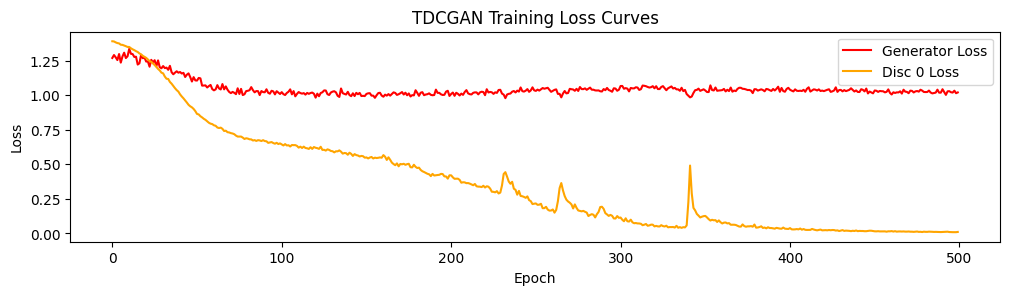

--- plot_3discs ---


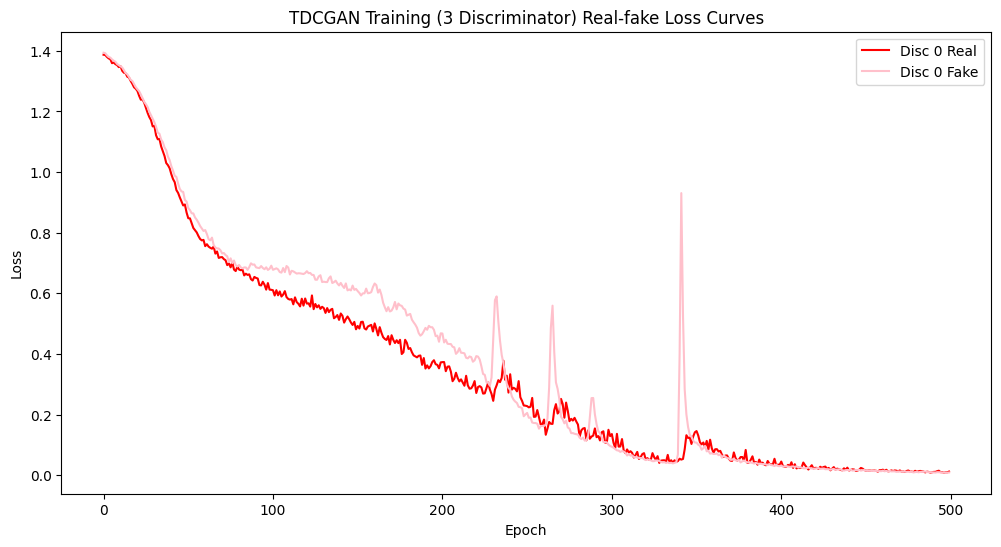

------------ Balance Data Using CGAN ------------
x_test_data shape :  (1200, 1619)
count features_test_cols:  1619
features_test_cols :  Index(['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8',
       'pca_9', 'pca_10',
       ...
       'pca_1610', 'pca_1611', 'pca_1612', 'pca_1613', 'pca_1614', 'pca_1615',
       'pca_1616', 'pca_1617', 'pca_1618', 'pca_1619'],
      dtype='object', length=1619)
labels_dic:  attack_type
1              619
0              581
Name: count, dtype: int64
max_class_sample:  619 
goal_rows_per_class:  619
num_samples_to_generate :  0
num_samples_to_generate :  38
We generate 38 synthetic samples for attack_type label (0,)
generated_data.shape:  (38, 1619)
labels_dic 2 len :  2
10
12
x_synthetic_data shape :  (38, 1619)
y_synthetic_data shape :  (38, 1)
x_synthetic_data head :  <bound method NDFrame.head of            pca_1         pca_2         pca_3         pca_4         pca_5  \
0   2.350987e-20  1.349101e-19  1.566895e-13  1.136798

In [ ]:

# ---------------------------> Definition <--------------------------- #
BATCH_SIZE = 128      #30   #batch_size = 16
NUM_EPOCHS = 500      # epoch_count = 50
#noise_dim = 100
#n_class = 10

# Save losses for plotting
cd_real_losses = []   # Real Data D losses
cd_fake_losses = []   # Fake data D losses
cd_losses      = []   # discriminator (D) losses
cg_losses      = []   # generator losses



# ---------------------------> Read Data of CSV Files <--------------------------- #
dataset_directory = "/content/datasets"   #files_path
percent = 100
data = read_csv_files(dataset_directory,percent)
print('len data : ' , len(data))

class_Col = 'attack_type'
min_rows_per_class = 2000  #50000
origin_data = data


# >> ---------------------------> Balance Data Before Start <--------------------------- #
#df_balanced_before = balance_data_before_tdcgan(data, class_Col, min_rows_per_class)
#data = df_balanced_before


# ---------------------------> Apply pre-processing <--------------------------- #
main_text_col = 'sentence'
n_classes, x_train_data, x_test_data, y_train, y_test, origin_x_train, origin_x_test, y_datatype = load_and_preprocess_data1(data)        ## pre-process way 2
num_classes = n_classes
print('-- End pre-process --')


# ---------------------------> Run TDCGAN Models (Gen., Disc., Comb.) - run_TDCGAN_models(old) <--------------------------- #
input_dim = x_train_data.shape[1]     # (features_dim) Dimensionality of TF-IDF vectors
print('features_dim shape: ', input_dim)

## Build the generator
print('G input_dim: ', input_dim)

generator_model = build_generator(input_dim, num_classes)   # random_noise_size / input_shape / input_dim

## Build multiple discriminators (3 disc.)
discriminators_model = []
discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_0', 3, [100, 100, 100], 0.1))

## Build the combined model (GAN Model)
combined_model = build_combined_model(input_dim, num_classes, generator_model, discriminators_model)



# ---------------------------> print_models_summary <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")

## Generator Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (TDCGAN): \n{TextStyle.RESET_ALL}")
generator_model.summary(show_trainable=True,expand_nested=True)   #generator_model.summary()

## Discriminators Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nDiscriminators summary (TDCGAN): \n{TextStyle.RESET_ALL}")
discriminators_model[0].summary(show_trainable=True,expand_nested=True)

## Combined Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (TDCGAN):\n{TextStyle.RESET_ALL} ")
combined_model.summary(show_trainable=True)



# ---------------------------> Train Model <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ train_model ------------{TextStyle.RESET_ALL}")
batch_size = BATCH_SIZE       # 128
noise_dim = input_dim
one_hot_encoder = train_cgan(BATCH_SIZE, noise_dim, num_classes, generator_model, discriminators_model, combined_model, x_train_data, y_train, NUM_EPOCHS)


# >> ---------------------------> Balance Data Using CGAN <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Balance Data Using CGAN ------------{TextStyle.RESET_ALL}")

goal_rows_per_class = 1000
features_test_cols = x_test_data.columns
print('x_test_data shape : ', x_test_data.shape)
print('count features_test_cols: ', len(features_test_cols))
print('features_test_cols : ' , features_test_cols)

x_synthetic_data, y_synthetic_data, synthetic_data = balance_data_using_cgan(y_test, input_dim, features_test_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype)


# add colum clear instance is real data or fake to help compare in evaluate step
# can't assume all real (1) m because we add new synthetic_data (fake) to them
y_test['is_real'] = np.ones(y_test.shape[0])
print('y_test.shape[0] : ', y_test.shape[0])

y_synthetic_data['is_real'] = np.zeros(y_synthetic_data.shape[0])


# Concatenate synthetic samples with the original dataset
new_x_test_data = pd.concat([x_test_data, x_synthetic_data], ignore_index=True, sort=False)
new_y_test_data = pd.concat([y_test, y_synthetic_data], ignore_index=True, sort=False)
print('new_x_test_data shape : ' , new_x_test_data.shape)
print('new_y_test_data shape : ' , new_y_test_data.shape)
print('new_x_test_data : ' , new_x_test_data)
print('new_y_test_data : ' , new_y_test_data)


print('x_test_data shape : ' , x_test_data.shape)
print('y_test shape : ' , y_test.shape)

print('x_synthetic_data shape : ' , x_synthetic_data.shape)
print('y_synthetic_data shape : ' , y_synthetic_data.shape)




# ---------------------------> Evaluate Model <--------------------------- #
#evaluate_cgan(x_test_data, y_test, n_classes, batch_size, one_hot_encoder)  #, encoder)
evaluate_cgan(new_x_test_data, new_y_test_data, n_classes, batch_size, one_hot_encoder, y_datatype)  #, encoder)

